<a href="https://colab.research.google.com/github/ArunaAcharya/CreditCardApprovalPrediction/blob/main/Creditcardapprovalprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Import necessary Packages</h3>

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os
%matplotlib inline

<h3> Import the csv file</h3>

In [ ]:
from scipy.stats import probplot, chi2_contingency, chi2

In [ ]:
cc_data_full_data= pd.read_csv("datasets/application_record.csv")
credit_status= pd.read_csv("datasets/credit_record.csv")

In [ ]:
cc_data_full_data.head()


ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

<h3>Creating the target variable</h3>

In [ ]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')

In [ ]:
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'

In [ ]:
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning Se

In [ ]:
 #cc_data_full_data.drop(['Account age_x','Account age_y'], axis=1, inplace=True)
cc_data_full_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  Account age Is high risk  
0              2.0        -15.0            0  
1              2.0        -14.0            0  
2              2.0        -29.0            0  
3              1.0         -4.0            0  
4              1.0        -26.0            0

In [ ]:
cc_data_full_data['Is high risk'].value_counts()

0    35841
1      616
Name: Is high risk, dtype: int64

<h2> Rename features</h2>

In [ ]:
cc_data_full_data= cc_data_full_data.rename(columns= {
    'CODE_GENDER': 'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY': 'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH': 'Age',
    'DAYS_EMPLOYED':'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    
})

In [ ]:
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age Is high risk  
0                  2.0        -15.0            0  
1                  2.0        -14.0            0  
2                  2.0        -29.0            0  
3                  1.0         -4.0            0  
4                  1.0        -26.0            0

<h3>Split the data into training and test sets, creating a copy of the datasets</h3>

In [ ]:
def data_split(df, test_size):
    train_df, test_df= train_test_split(df, test_size= test_size, random_state= 42)
    return train_df.reset_index(drop= True), test_df.reset_index(drop= True)

In [ ]:
cc_train_original, cc_test_original= data_split(cc_data_full_data, 0.2)

In [ ]:
cc_train_original.to_csv('datasets/train.csv', index= False)

In [ ]:
cc_test_original.to_csv('datasets/test.csv', index= False)

In [ ]:
cc_train_copy= cc_train_original.copy()

In [ ]:
cc_test_copy= cc_test_original.copy()

<h1> Explore the Data</h1>

<h3>Pandas Profiling</h3>

In [ ]:
profile_report= ProfileReport(cc_train_copy, explorative= True, dark_mode= True)
profile_report_file_path= Path('pandas_profile_file/credit_pred_profile.html')
try:
    profile_report_file_path.resolve(strict= True)
except FileNotFoundError:
    profile_report.to_file("pandas_profile_file/credit_pred_profile.html")

<h1>New data</h1>

In [ ]:
cc_data_full_data.head()


ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age Is high risk  
0                  2.0        -15.0            0  
1                  2.0        -14.0            0  
2                  2.0        -29.0            0  
3                  1.0         -4.0            0  
4                  1.0        -26.0            0

In [ ]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

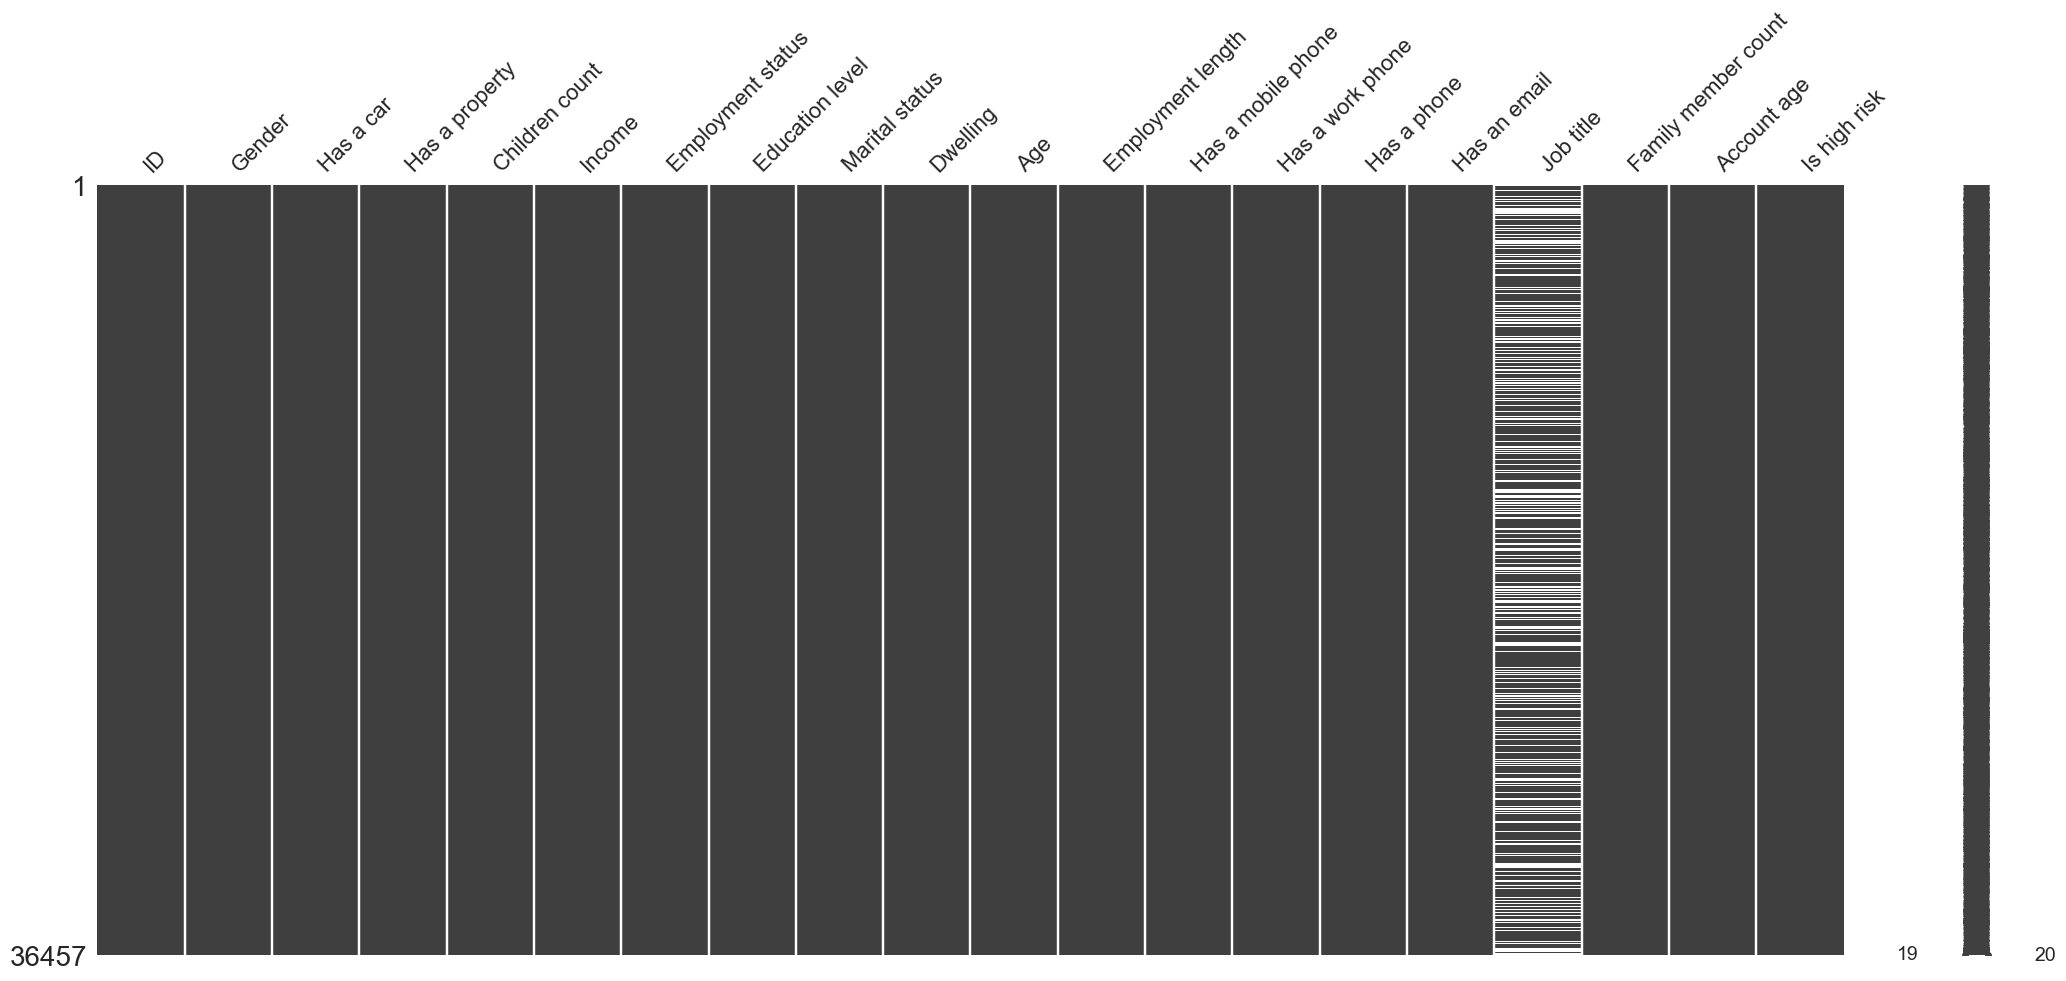

In [ ]:
msno.matrix(cc_data_full_data)
plt.show()

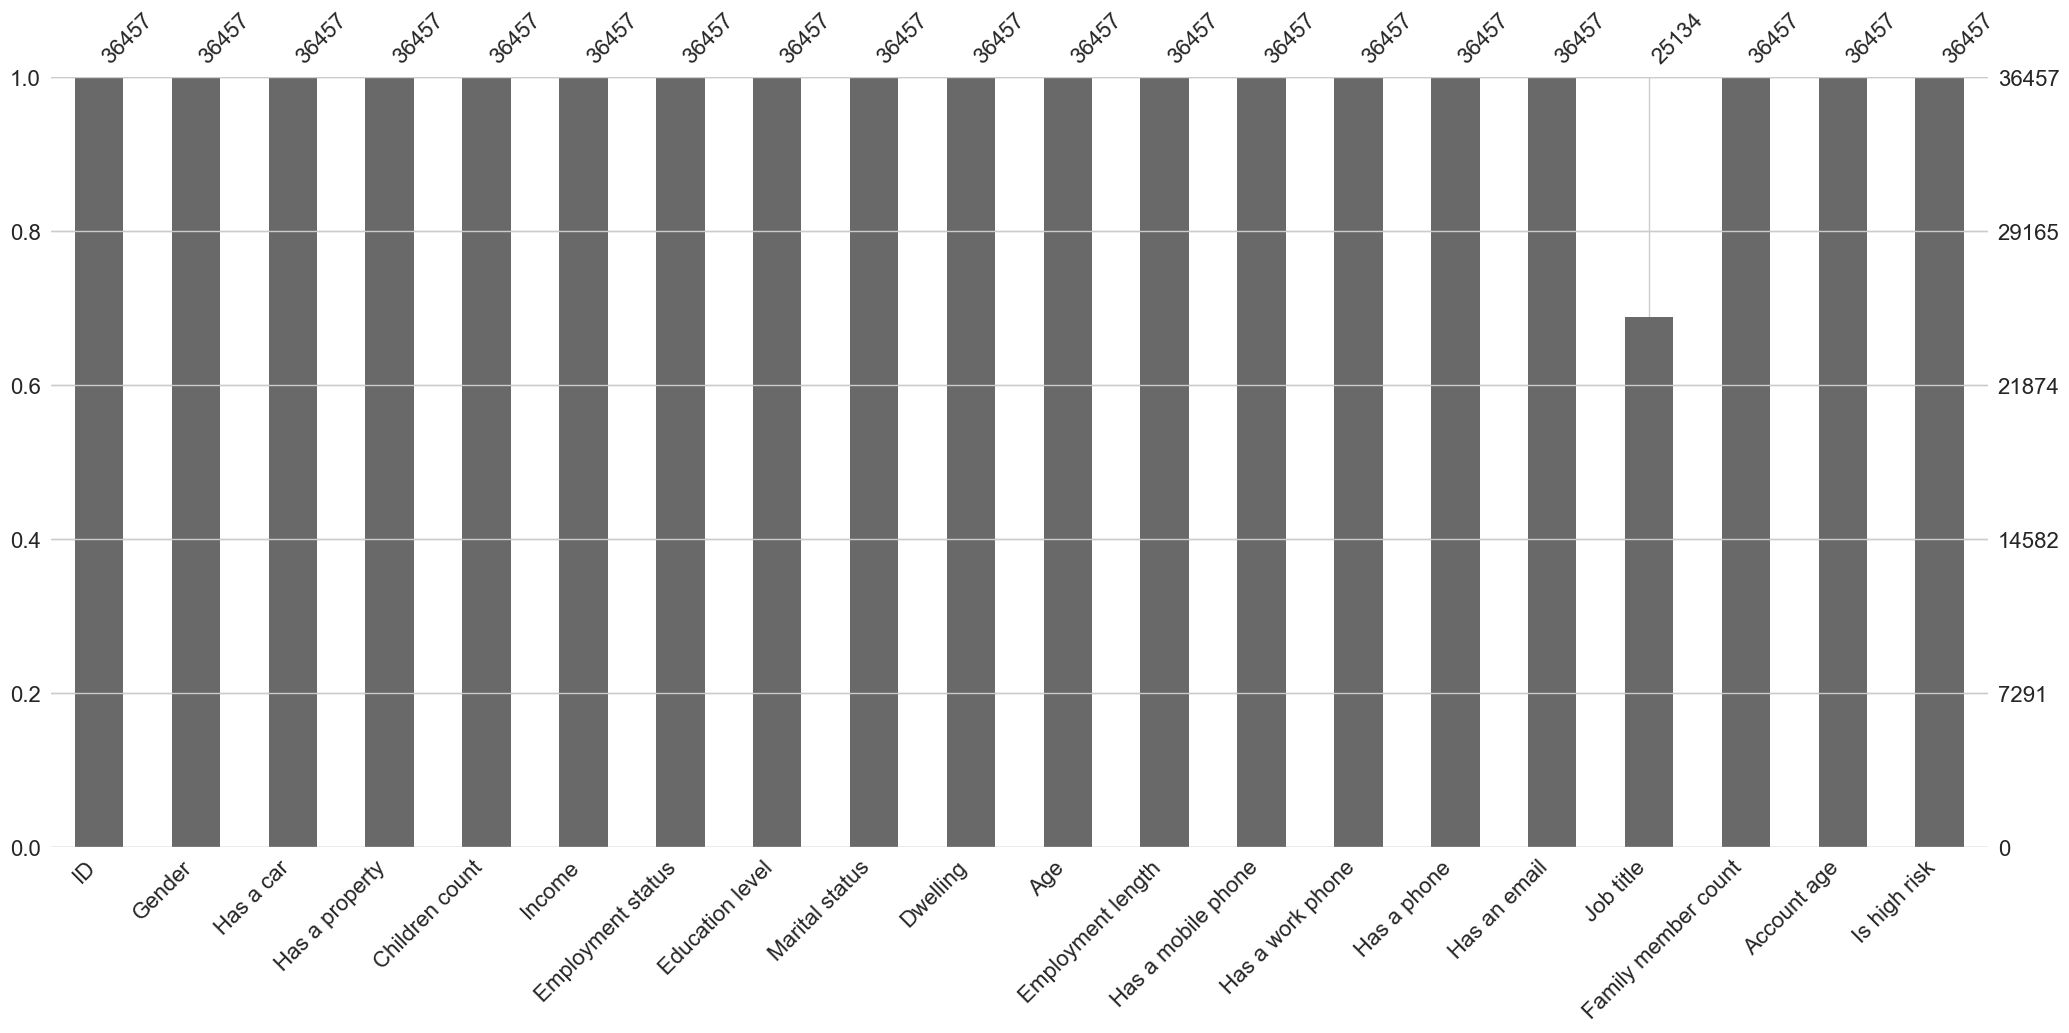

In [ ]:
msno.bar(cc_data_full_data)
plt.show()

<h3>Functions used to explore each feature</h3>

In [ ]:
def value_cnt_norm_cal(df, feature):
    ftr_value_cnt= df[feature].value_counts()
    ftr_value_cnt_norm= df[feature].value_counts(normalize= True)*100
    ftr_value_cnt_concat= pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis= 1)
    ftr_value_cnt_concat.columns= ['Count', 'Frequency(%)']
    return ftr_value_cnt_concat

In [ ]:
def get_info_feat(df,feature):
    if feature == 'Age':
        #change the feature to be express in positive numbers days
        print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    elif feature == 'Employment length':
        #select only the rows where the rows are negative to ifnore those who have retired or unemployed
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
        print('*'*50)
        print('Object type:{}'.format(employment_len_no_ret.dtype))
    elif feature == 'Account age':
        #change the account age to a positive number of months
        print('Description:\n{}'.format((np.abs(df[feature])).describe()))
        print('_'*50)
        print('Object type:{}'.format(df[feature].dtype))
    else:
              print('Description:\n{}'.format(df[feature].describe()))
              print('_'*50)
              print('Object type:\n{}'.format(df[feature].dtype))
              print('_'*50)
              value_cnt = value_cnt_norm_cal(df,feature)
              print('Value count:\n{}'.format(value_cnt))

                

<h1> Pie Plot</h1>

In [ ]:
def create_pie_plot(df, feature):
    if feature == 'Dwelling' or feature =="Education level":
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency(%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        # ratio_size= value_cnt_norm_cal(df, feature)
        # ratio_size_len= len(ratio_size.index)
        # ratio_list= []
        # for i in range (ratio_size_len):
        #     ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        # fig, ax= plt.subplots(figsize= (8,8))
        # #1.2f%% display decimals in the pie chart with 2 decimal in places
        plt.pie(ratio_list, startangle= 90, wedgeprops= {'edgecolor':'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc= 'best', labels= ratio_size.index)
        plt.axis('equal')
        return plt.show()
    else:
        ratio_size= value_cnt_norm_cal(df, feature)
        ratio_size_len= len(ratio_size.index)
        ratio_list=[]
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency(%)'])
        fig, ax= plt.subplots(figsize= (8,8))
        plt.pie(ratio_list, labels= ratio_size.index, autopct= '%1.2f%%', startangle= 90, wedgeprops= {'edgecolor':'black'})
        plt.legend(loc= 'best')
        plt.axis('equal')
        return plt.show()
        

<h1> Bar plot</h1>

In [ ]:
#create bar plot
def create_bar_plot(df, feature):
    if feature == "Marital status" or feature == "Dwelling" or feature == "Job title" or feature == "Employment status" or feature == "Education level":
        fig, ax = plt.subplots(figsize= (6,10))
        sns.barplot(x= value_cnt_norm_cal(df,feature). index, y= value_cnt_norm_cal(df, feature).values[:,0])
        ax.set_xticklabels(labels= value_cnt_norm_cal(df, feature).index, rotation= 45, ha= "right")
        plt.xlabel('{}' .format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show
    else:
        fig, ax= plt.subplots(figsize= (6,10))
        sns.barplot(x= value_cnt_norm_cal(df, feature).index, y= value_cnt_norm_cal(df, feature).values[:,0])
        plt.ylabel('count')
        plt.xlabel('{}'.format(feature))
        plt.title('{} count'.format(feature))
        return plt.show()
        
        

<h1>Box plot</h1>

In [ ]:
def create_box_plot(df,feature):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        # change the feature to be express in positive numbers days
        sns.boxplot(y=np.abs(df[feature])/365.25)
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    elif feature==  'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    elif feature == 'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        # employement length in days is a negative number so we need to change it to positive and change it to days
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    elif feature ==  'Income':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        # suppress scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        return plt.show()
    elif feature== 'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()

<h1>Hist plot</h1>

In [ ]:
def create_hist_plot(df, feature, the_bins= 50):
    fig, ax= plt.subplots(figsize= (18,10))
    if feature == 'Age':
        sns.histplot(np.abs(df[feature])/365.25, bins= the_bins, kde= True)
    elif feature =="Income":
        sns.histplot(df[feature], bins= the_bins, kde = True)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    elif feature == 'Employment length':
        employment_len_no_ret= cc_train_copy['Employment length'][cc_train_copy['Employment length']<0]
        employment_len_no_ret_yrs= np.abs(employment_len_no_ret)/365.25
        sns.histplot(employment_len_no_ret_yrs, bins= the_bins, kde= True)
    elif feature == "Account age":
        sns.histplot(np.abs(df[feature]), bins= the_bins, kde= True)
    else:
        sns.histplot(df[feature], bins= the_bins, kde= True)
    plt.title('{} distribution'.format(feature))
    return plt.show()

<h1>Low High Risk Box Plot</h1>

In [ ]:
# def low_high_risk_box_plot(df, feature):
#     mean= df.groupby('Is high risk')[feature].mean()
#     fig, ax= plt.subplots(figsize=(5,8))
#     sns.boxplot(y= df[feature], x= df['Is high risk'])
#     plt.xticks(ticks= [0,1], labels= ['no', 'yes'])
    
#     if feature == 'Age':
#         print(np.abs(mean))
#         sns.boxplot(y= np.abs(df[feature])/365.25,
#                     x= df['Is high risk'])
#     elif feature == 'Income':
#         print(np.abs(mean))
#         sns.boxplot(y= np.abs(df[feature]),
#                    x= df['Is high risk'])
#         ax.get_yaxis().set_major_formatter(
#         matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), " , ")))
#     elif feature == "Employment length":
        
#         # checking the age of hifh risk individuals with the age of low risk individuals (those who are employed)
#         employment_no_ret= cc_train_copy['Employment length'][cc_train_copy['Employment length']<0]
#         employment_no_ret_idx= employment_no_ret.index
#         employment_len_no_ret_yrs= np.abs(employment_no_ret)/365.25
#         employment_len_no_ret_df= cc_train_copy.iloc[employment_no_ret_idx][['Employment length', 'Is high risk']]
#         employment_no_ret_is_high_risk= employment_len_no_ret_df.groupby('Is high risk')['Employment length'].mean()
#         print(np.abs(employment_no_ret_is_high_risk)/365.25)
#         # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
#         # print(np.abs(employment_no_ret_is_high_risk)/365.25)
#         sns.boxplot(y= employment_len_no_ret_yrs, x= df['Is high risk'])
#     else:
#         print(np.abs(mean))
#         sns.boxplot(y= np.abs(df[feature]), x= df['Is high risk'])
#     plt.title('High risk individuals grouped by {}'. format(feature))
#     return plt.show()

<h1> Low high Risk Bar Plot</h1>

In [ ]:
print(np.abs(cc_train_copy.groupby('Is high risk')['Age'].mean()/365.25))

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


In [ ]:
# High risk vs low risk applicants compared on a box plot
def low_high_risk_box_plot(df,feature):
    if feature== 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
    elif feature =='Income':
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        # suppress scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()
    elif feature== 'Employment length':
        #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
        employment_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] <0]
        employment_no_ret_idx = employment_no_ret.index
        employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
        employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
        employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
        # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
        print(np.abs(employment_no_ret_is_high_risk)/365.25)
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High vs low risk individuals grouped by {}'.format(feature))
        return plt.show()
    else:
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()
   

<h1>Low high Risk Bar Plot
</h1>

In [ ]:
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    # print(dict(is_high_risk_grp_srt))
    mean_val= df['Is high risk'].mean()
    median_val= df['Is high risk'].median()
    
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    
    ax.axhline(y= mean_val, color= 'red', label= 'mean')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()


<h1>Univariate Analysis</h1>

<h1>Gender</h1>

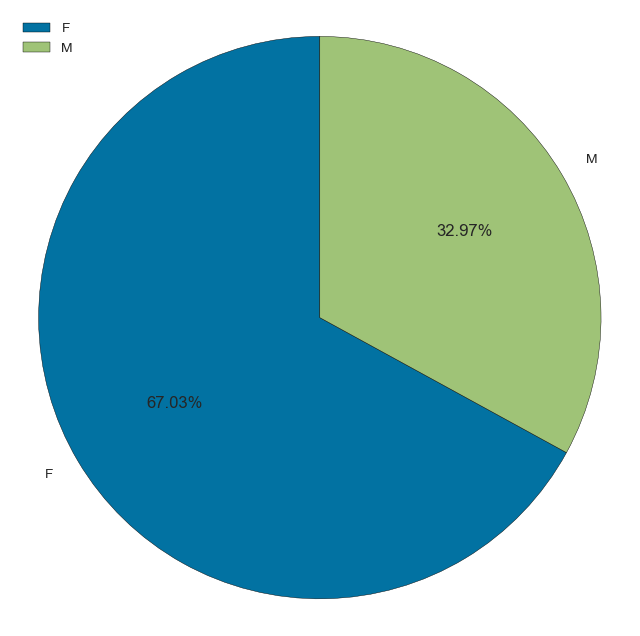

In [ ]:
create_pie_plot(cc_train_copy, 'Gender')

Interpretation:
Majority of the applicants are Female

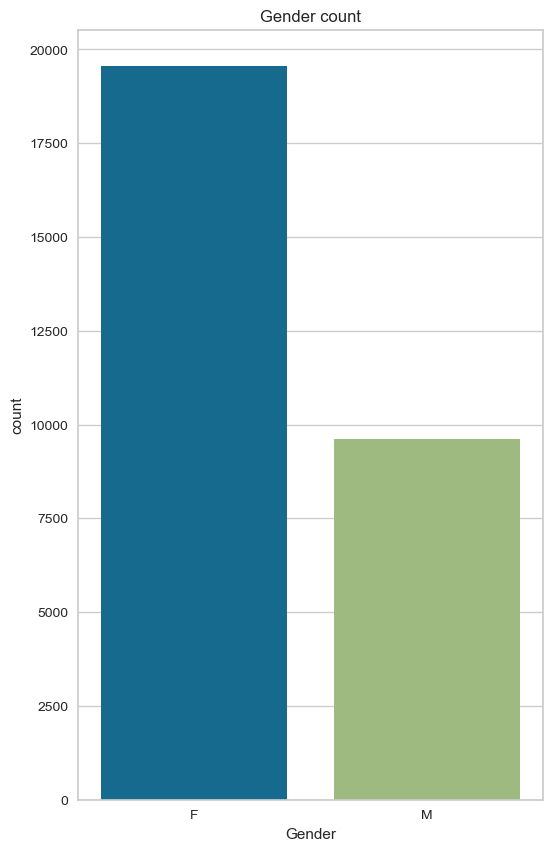

In [ ]:
create_bar_plot(cc_train_copy, 'Gender')

<h1> Age</h1>

In [ ]:
get_info_feat(cc_train_copy, 'Age')

Description:
count    29165.000000
mean        43.749425
std         11.507180
min         21.095140
25%         34.154689
50%         42.614648
75%         53.234771
max         68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64


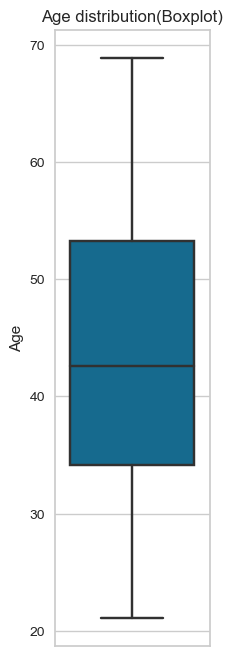

In [ ]:
create_box_plot(cc_train_copy, 'Age')

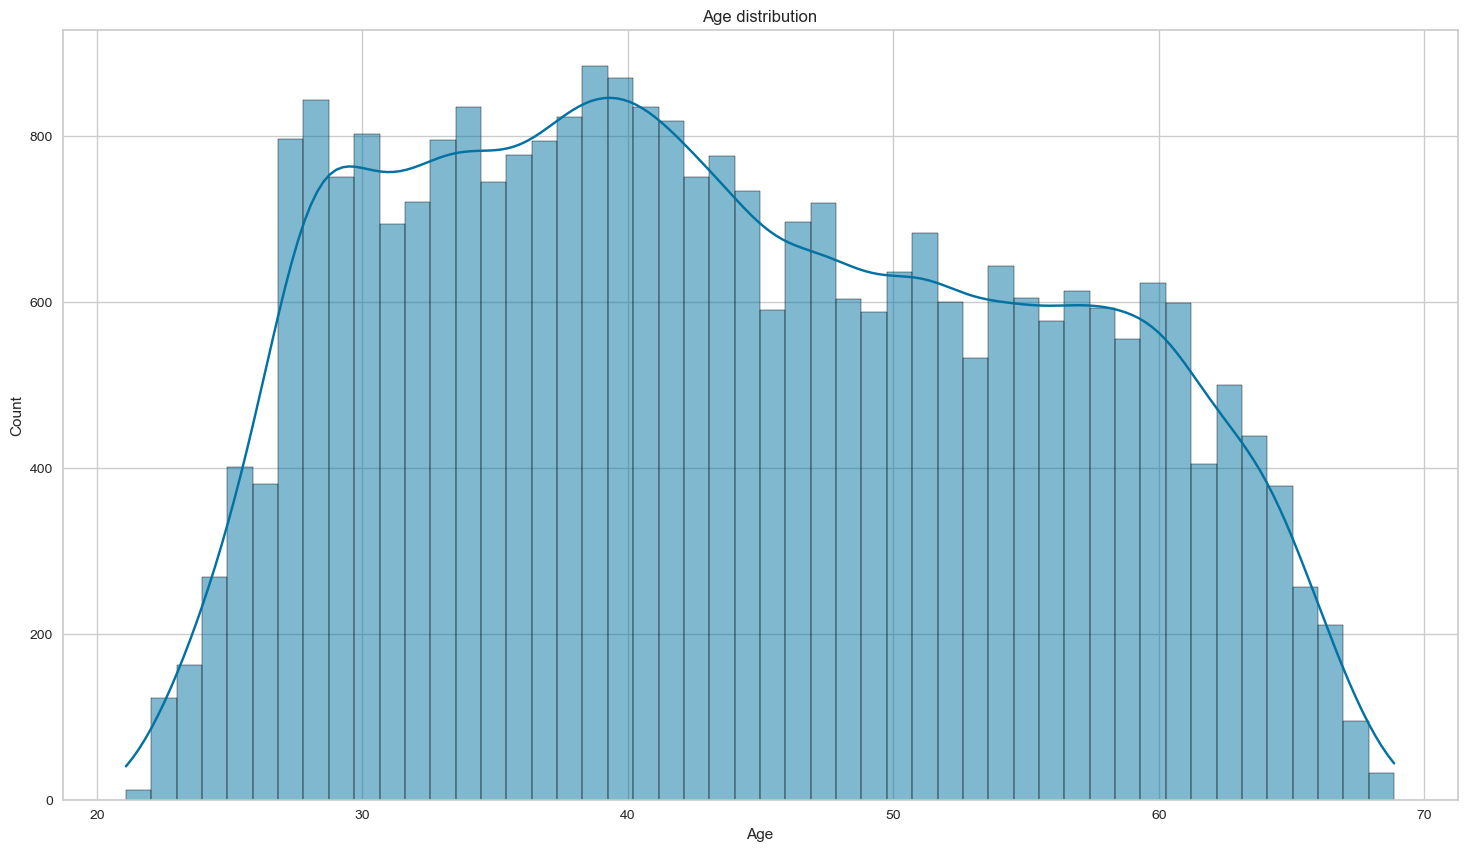

In [ ]:
create_hist_plot(cc_train_copy, 'Age')

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


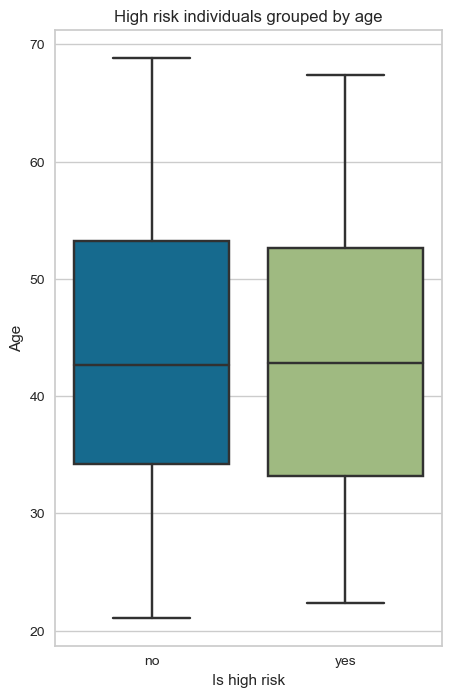

In [ ]:
low_high_risk_box_plot(cc_train_copy, 'Age')

<h1>Marital Status</h1>


In [ ]:
get_info_feat(cc_train_copy, 'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                      Count  Frequency(%)
Married               20044     68.726213
Single / not married   3864     13.248757
Civil marriage         2312      7.927310
Separated              1712      5.870050
Widow                  1233      4.227670


<function matplotlib.pyplot.show(close=None, block=None)>

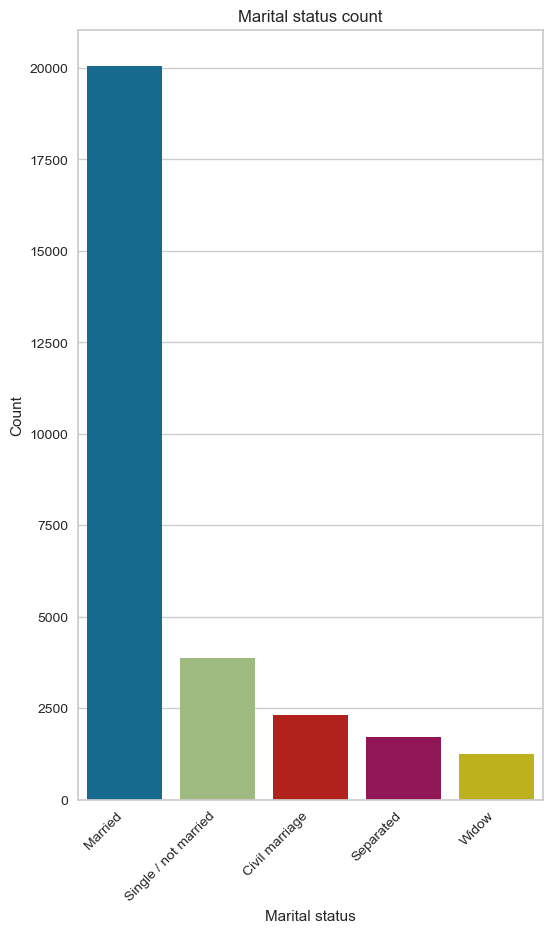

In [ ]:
create_bar_plot(cc_train_copy, 'Marital status')

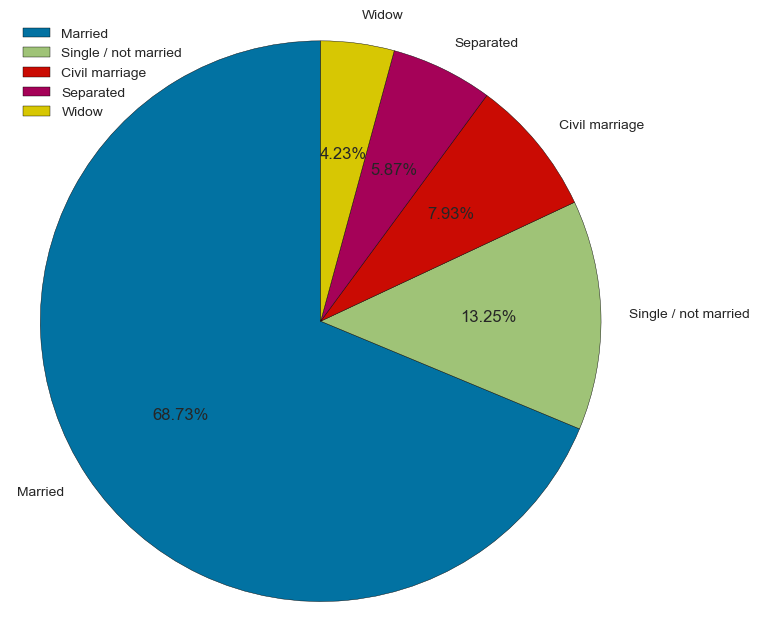

In [ ]:
create_pie_plot(cc_train_copy, 'Marital status')

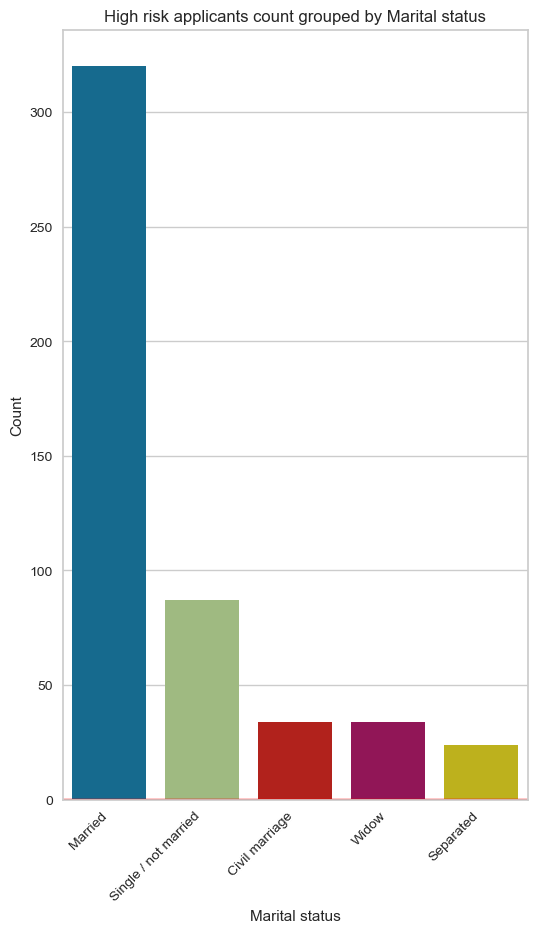

In [ ]:
low_high_risk_bar_plot(cc_train_copy, 'Marital status')

<h1>Family member count</h1>

In [ ]:
get_info_feat(cc_train_copy,"Family member count")

Description:
count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64
__________________________________________________
Object type:
float64
__________________________________________________
Value count:
      Count  Frequency(%)
2.0   15552     53.324190
1.0    5613     19.245671
3.0    5121     17.558718
4.0    2503      8.582205
5.0     309      1.059489
6.0      48      0.164581
7.0      14      0.048003
9.0       2      0.006858
15.0      2      0.006858
20.0      1      0.003429


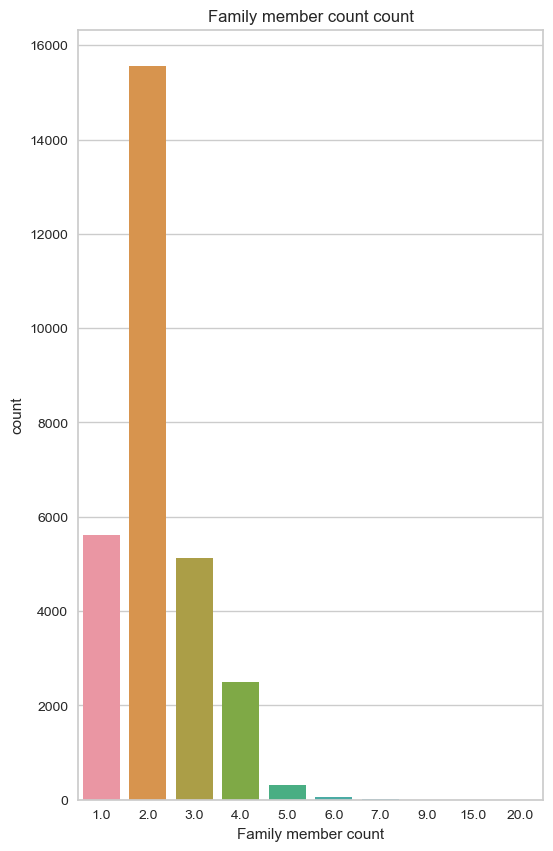

In [ ]:
create_bar_plot(cc_train_copy, "Family member count")

- Majority of the applicants have a family member of 2 that means they dont have a child


Is high risk
0    2.198284
1    2.154309
Name: Family member count, dtype: float64


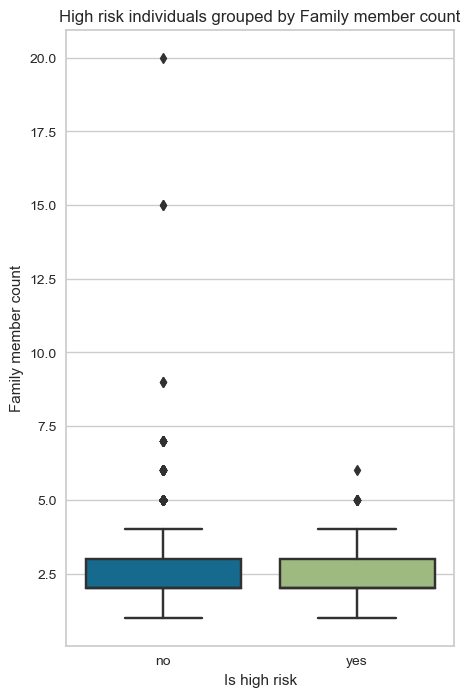

In [ ]:
low_high_risk_box_plot(cc_train_copy, "Family member count")

<h1>Children Count</h1>

In [ ]:
get_info_feat(cc_train_copy, "Children count")

Description:
count    29165.000000
mean         0.430790
std          0.741882
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64
__________________________________________________
Object type:
int64
__________________________________________________
Value count:
    Count  Frequency(%)
0   20143     69.065661
1    6003     20.582890
2    2624      8.997086
3     323      1.107492
4      52      0.178296
5      15      0.051432
7       2      0.006858
14      2      0.006858
19      1      0.003429


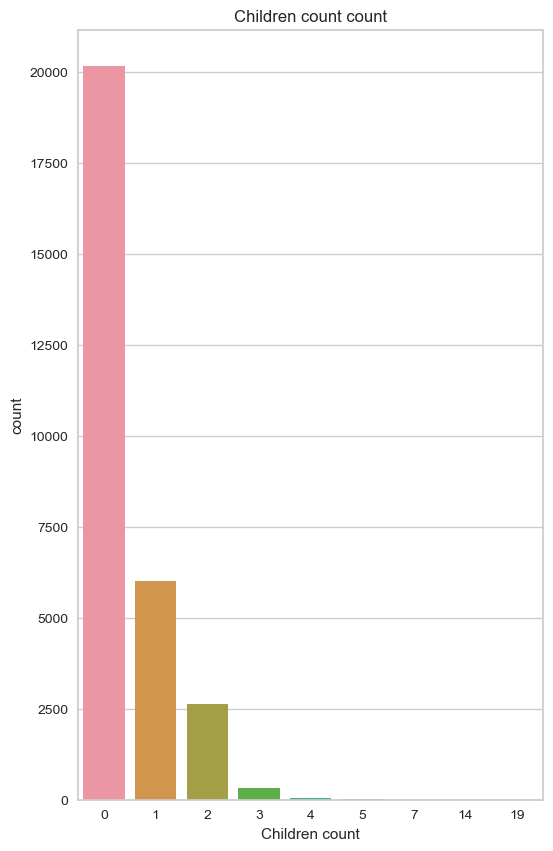

In [ ]:
create_bar_plot(cc_train_copy, "Children count")

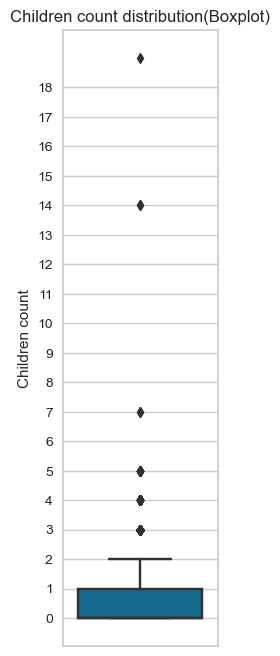

In [ ]:
create_box_plot(cc_train_copy, "Children count")

As previously seen on family member count majority of the applicants dont have children 

<h1>Dwelling Type</h1>

In [ ]:
get_info_feat(cc_train_copy, "Dwelling")

Description:
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                     Count  Frequency(%)
House / apartment    26059     89.350249
With parents          1406      4.820847
Municipal apartment    912      3.127036
Rented apartment       453      1.553232
Office apartment       208      0.713184
Co-op apartment        127      0.435453


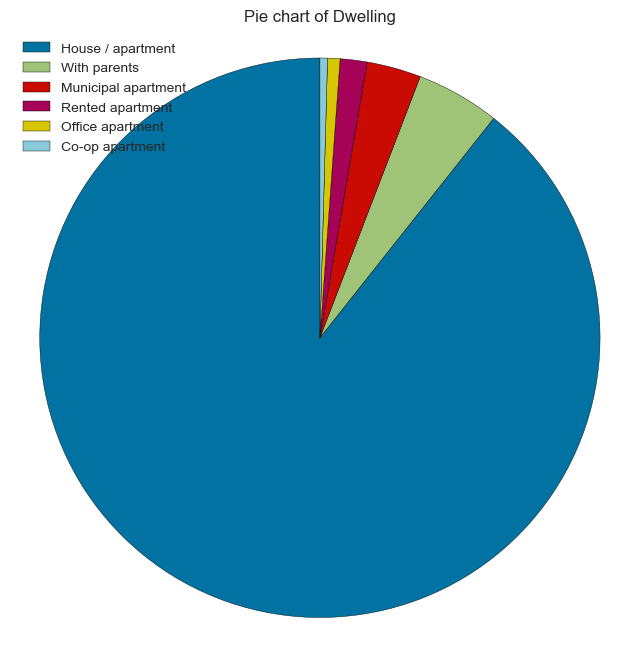

In [ ]:
create_pie_plot(cc_train_copy, "Dwelling")

<function matplotlib.pyplot.show(close=None, block=None)>

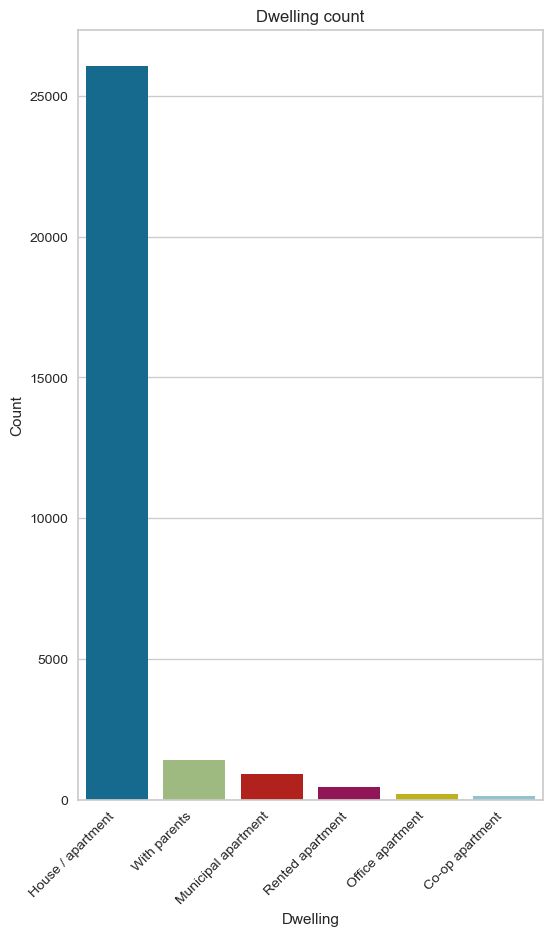

In [ ]:
create_bar_plot(cc_train_copy,"Dwelling")

# Income

In [ ]:
get_info_feat(cc_train_copy, "Income")

Description:
count    2.916500e+04
mean     1.868904e+05
std      1.014096e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: Income, dtype: float64
__________________________________________________
Object type:
float64
__________________________________________________
Value count:
          Count  Frequency(%)
135000.0   3468     11.890965
180000.0   2487      8.527344
157500.0   2469      8.465627
225000.0   2373      8.136465
112500.0   2359      8.088462
...         ...           ...
164250.0      1      0.003429
42300.0       1      0.003429
432000.0      1      0.003429
145350.0      1      0.003429
82350.0       1      0.003429

[259 rows x 2 columns]


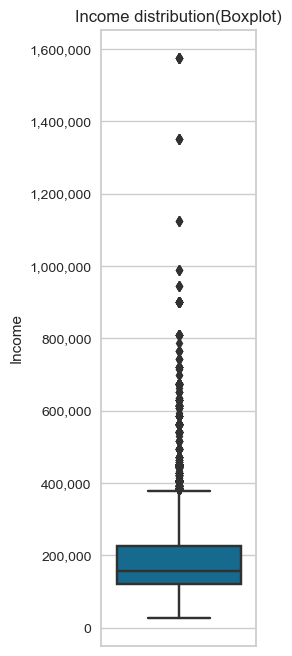

In [ ]:
create_box_plot(cc_train_copy, "Income")

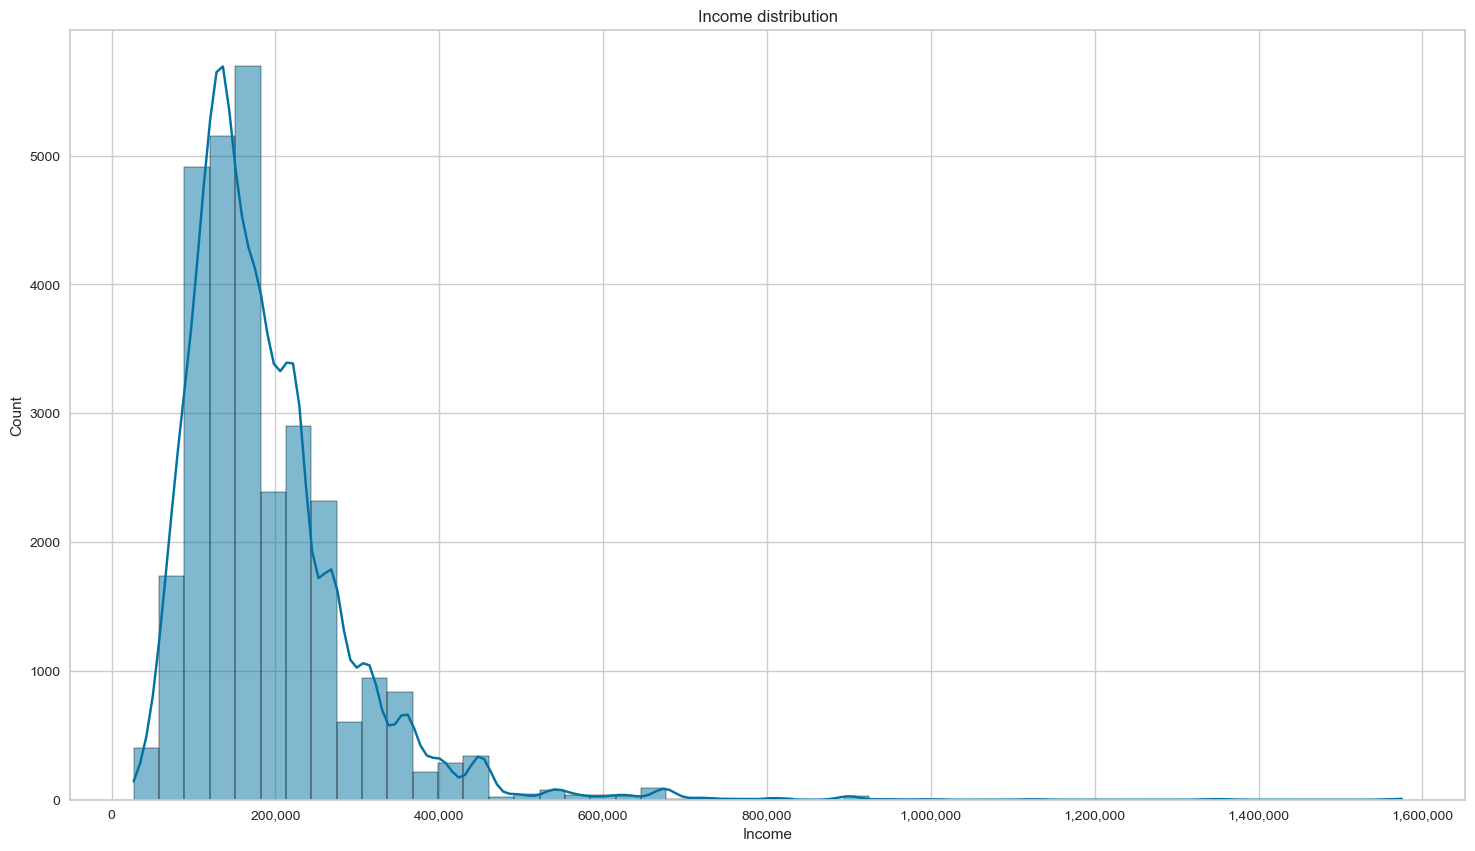

In [ ]:
create_hist_plot(cc_train_copy, "Income")

Is high risk
0    186913.939650
1    185537.263527
Name: Income, dtype: float64


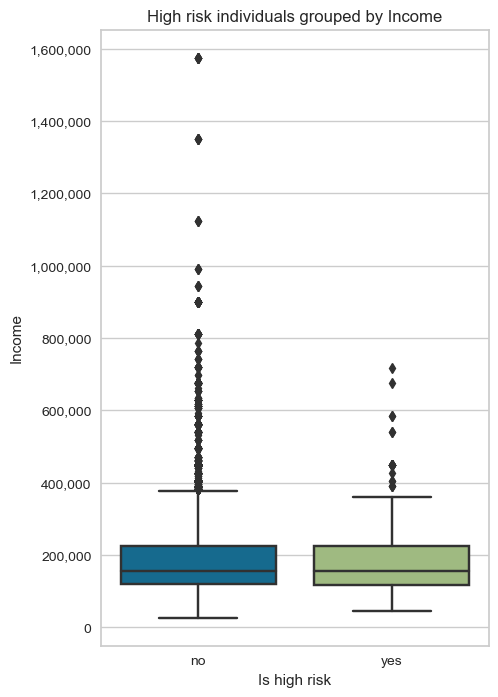

In [ ]:
low_high_risk_box_plot(cc_train_copy, "Income")

# Job Title

In [ ]:
get_info_feat(cc_train_copy, "Job title")

Description:
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                       Count  Frequency(%)
Laborers                5004     24.848545
Core staff              2866     14.231801
Sales staff             2773     13.769987
Managers                2422     12.027014
Drivers                 1722      8.550998
High skill tech staff   1133      5.626179
Accountants              998      4.955805
Medicine staff           956      4.747244
Cooking staff            521      2.587149
Security staff           464      2.304102
Cleaning staff           425      2.110438
Private service staff    287      1.425166
Low-skill Laborers       138      0.685272
Waiters/barmen staff     127      0.630649
Secretaries              122      0.605820
HR staff                  72      0.357533
Realty agents 

In [ ]:
print(f"Total row: {cc_train_copy.shape[0]}")
print(f"Missing rows: {cc_train_copy['Job title'].isna().sum()}")
print("The percentage of missing rows is {:.2f} %" .format( (cc_train_copy['Job title'].isna().sum())*100 /(cc_train_copy.shape[0])) )

Total row: 29165
Missing rows: 9027
The percentage of missing rows is 30.95 %


<function matplotlib.pyplot.show(close=None, block=None)>

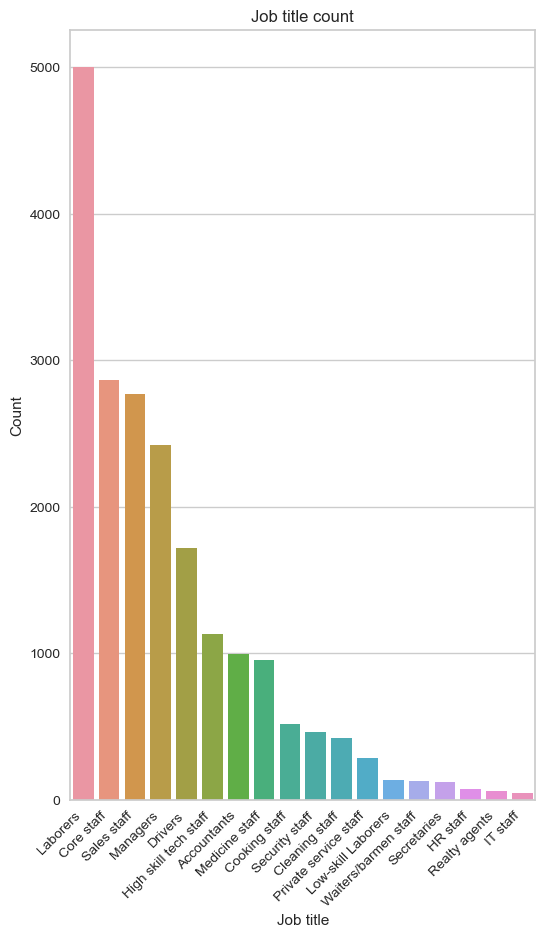

In [ ]:
create_bar_plot(cc_train_copy, 'Job title')

# Employment Status

In [ ]:
get_info_feat(cc_train_copy, 'Employment status')

Description:
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                      Count  Frequency(%)
Working               15056     51.623521
Commercial associate   6801     23.319047
Pensioner              4920     16.869535
State servant          2381      8.163895
Student                   7      0.024001


<function matplotlib.pyplot.show(close=None, block=None)>

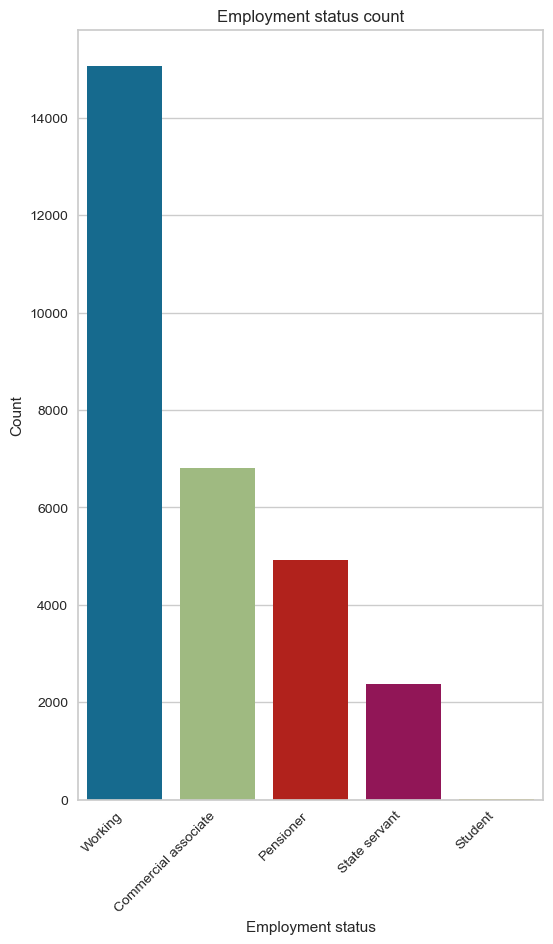

In [ ]:
create_bar_plot(cc_train_copy, "Employment status")

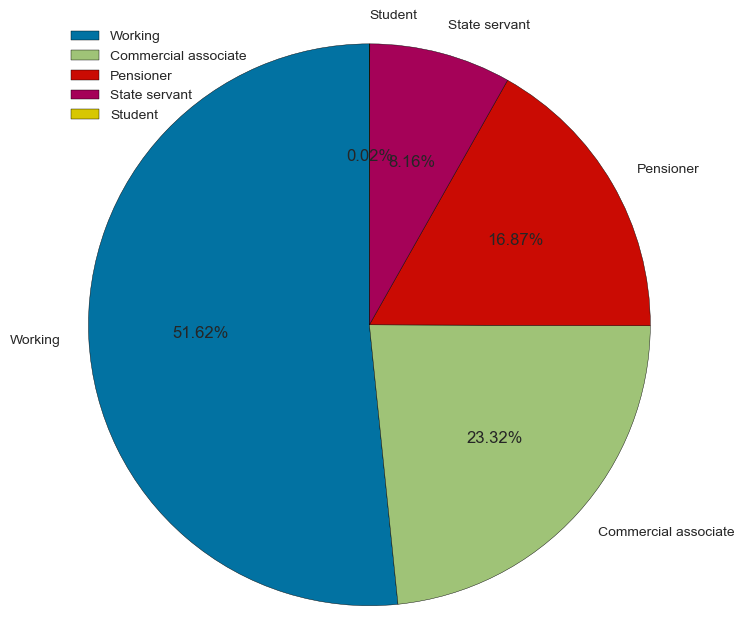

In [ ]:
create_pie_plot(cc_train_copy, "Employment status")

# Education Level

In [ ]:
get_info_feat(cc_train_copy,"Education level" )

Description:
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                               Count  Frequency(%)
Secondary / secondary special  19803     67.899880
Higher education                7910     27.121550
Incomplete higher               1129      3.871078
Lower secondary                  298      1.021773
Academic degree                   25      0.085719


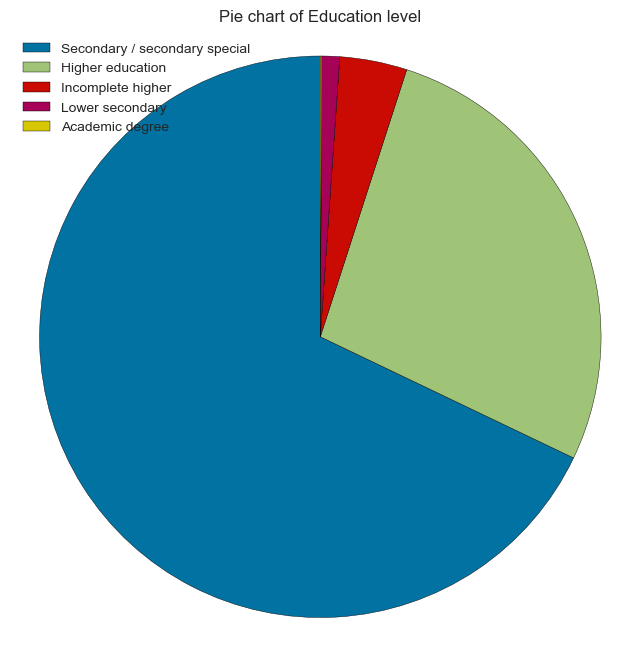

In [ ]:
create_pie_plot(cc_train_copy, "Education level")

<function matplotlib.pyplot.show(close=None, block=None)>

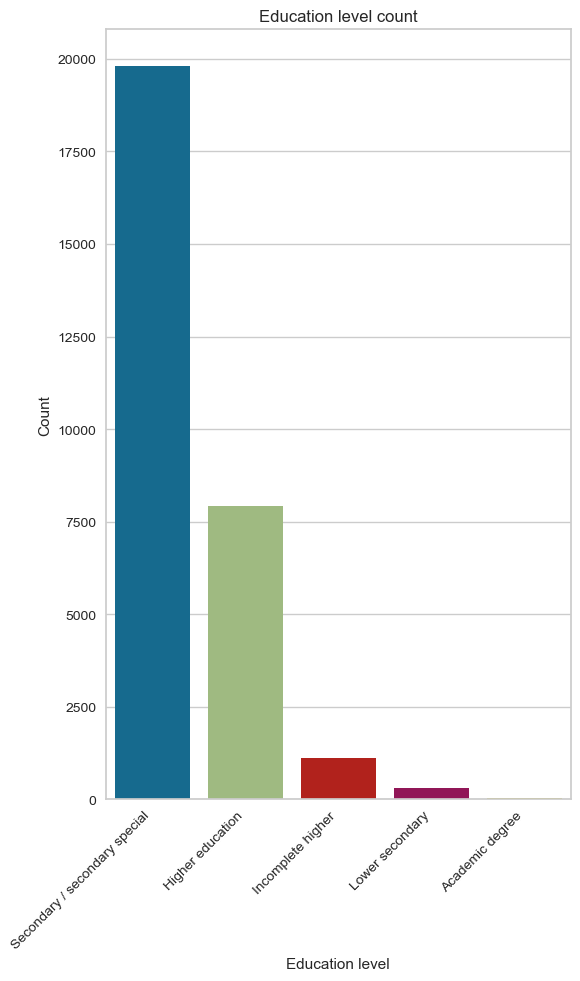

In [ ]:
create_bar_plot(cc_train_copy, "Education level")

# Has a phone

In [ ]:
get_info_feat(cc_train_copy, "Has a phone")

Description:
count    29165.000000
mean         0.294977
std          0.456040
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Has a phone, dtype: float64
__________________________________________________
Object type:
int64
__________________________________________________
Value count:
   Count  Frequency(%)
0  20562     70.502314
1   8603     29.497686


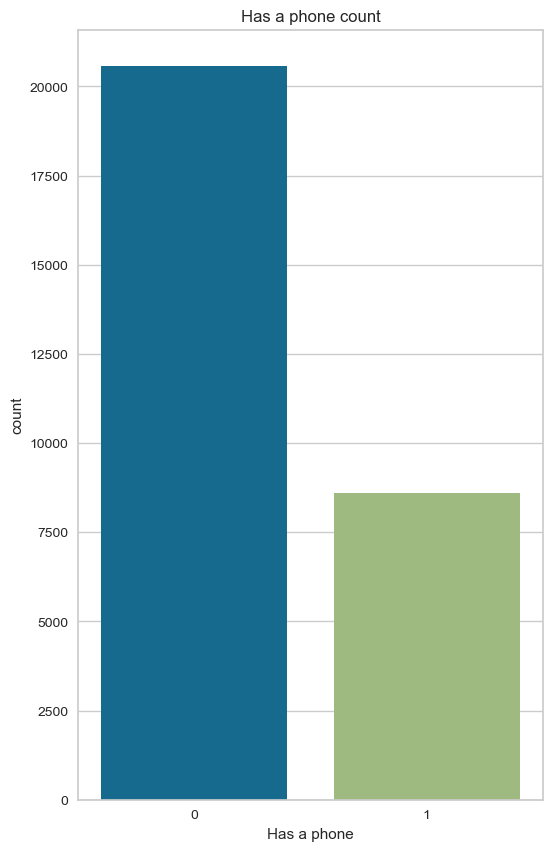

In [ ]:
create_bar_plot(cc_train_copy, "Has a phone")

Surprisingly, most applicants does not have a phone.

# Has an email


In [ ]:
get_info_feat(cc_train_copy, "Has an email")

Description:
count    29165.000000
mean         0.090279
std          0.286587
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Has an email, dtype: float64
__________________________________________________
Object type:
int64
__________________________________________________
Value count:
   Count  Frequency(%)
0  26532     90.972056
1   2633      9.027944


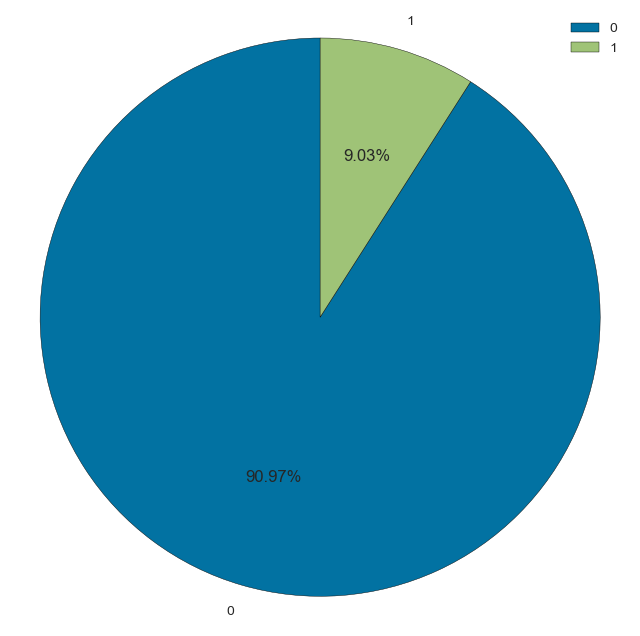

In [ ]:
create_pie_plot(cc_train_copy, "Has an email")

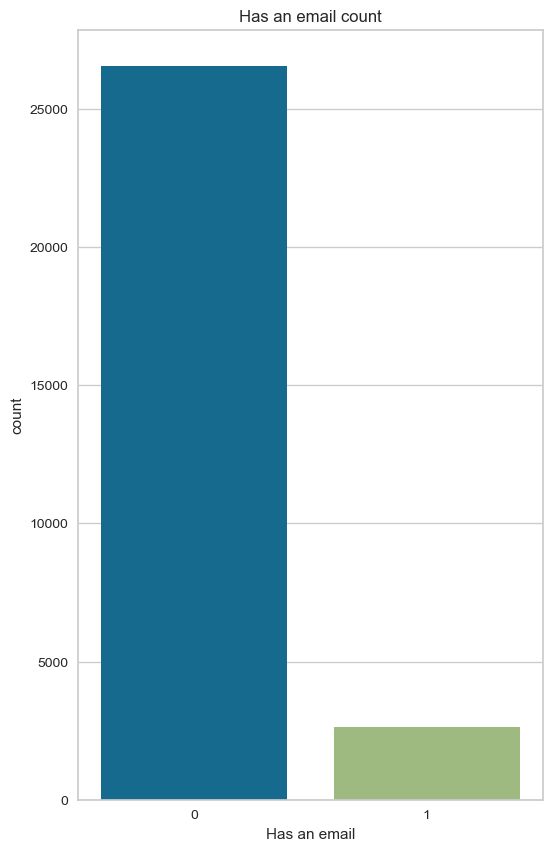

In [ ]:
create_bar_plot(cc_train_copy, "Has an email")

Unbelievable !! More than 90% of applicant don't have an email

# Account Age

In [ ]:
get_info_feat(cc_train_copy, "Account age")

Description:
count    29165.000000
mean        26.137734
std         16.486702
min          0.000000
25%         12.000000
50%         24.000000
75%         39.000000
max         60.000000
Name: Account age, dtype: float64
__________________________________________________
Object type:float64


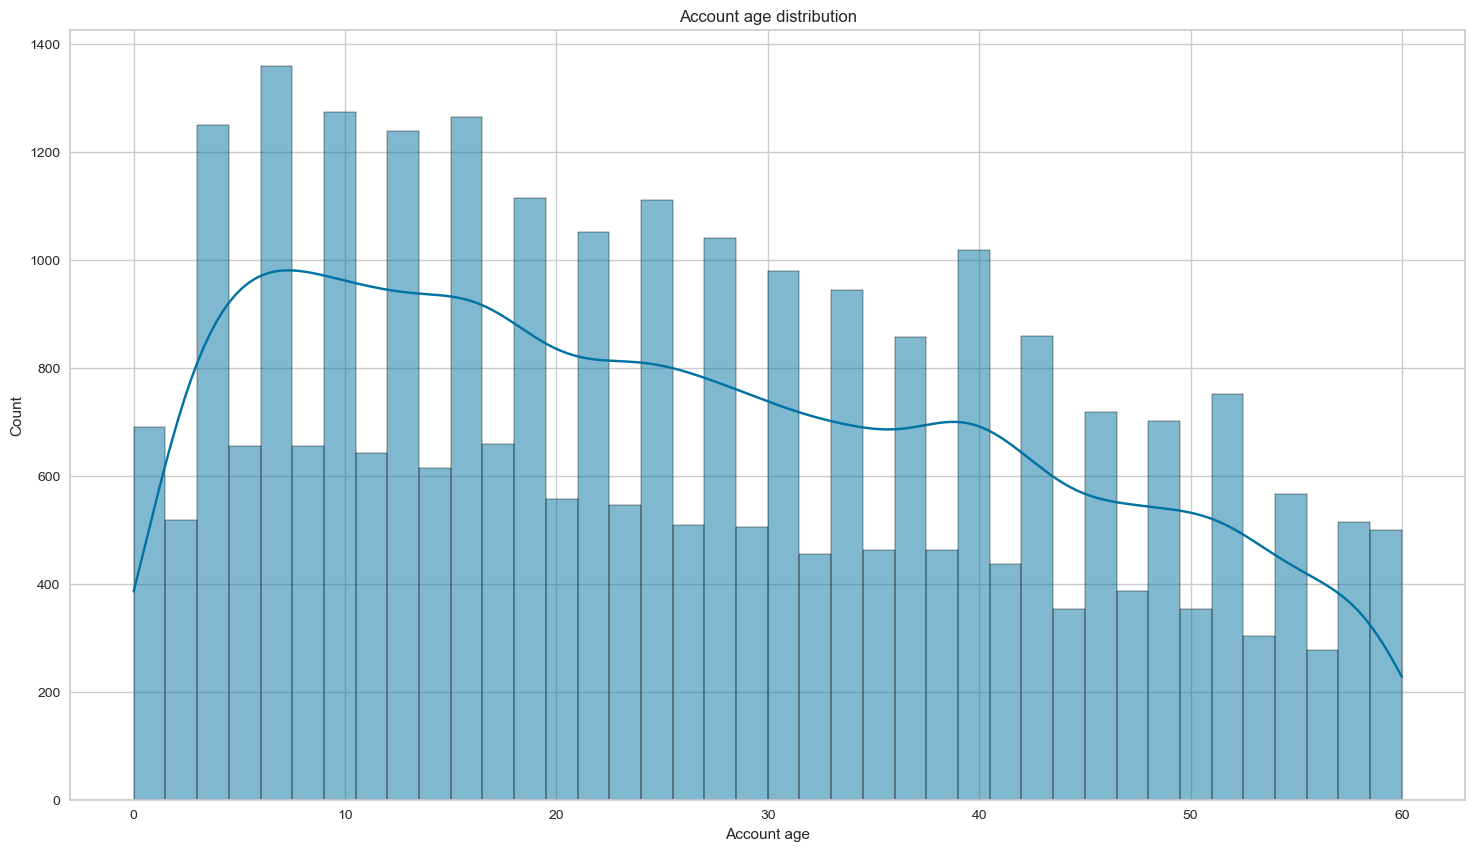

In [ ]:
create_hist_plot(cc_train_copy, "Account age", the_bins= 40)

Is high risk
0    26.000105
1    34.044088
Name: Account age, dtype: float64


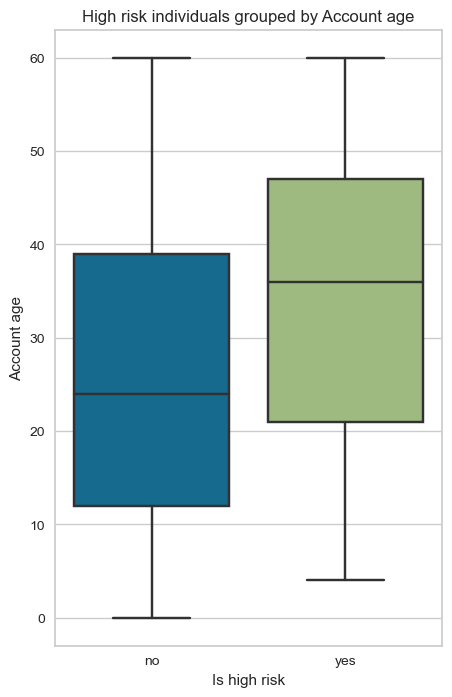

In [ ]:
low_high_risk_box_plot(cc_train_copy, "Account age")

# Is high risk

In [ ]:
get_info_feat(cc_train_copy, "Is high risk")

Description:
count     29165
unique        2
top           0
freq      28666
Name: Is high risk, dtype: int64
__________________________________________________
Object type:
object
__________________________________________________
Value count:
   Count  Frequency(%)
0  28666     98.289045
1    499      1.710955


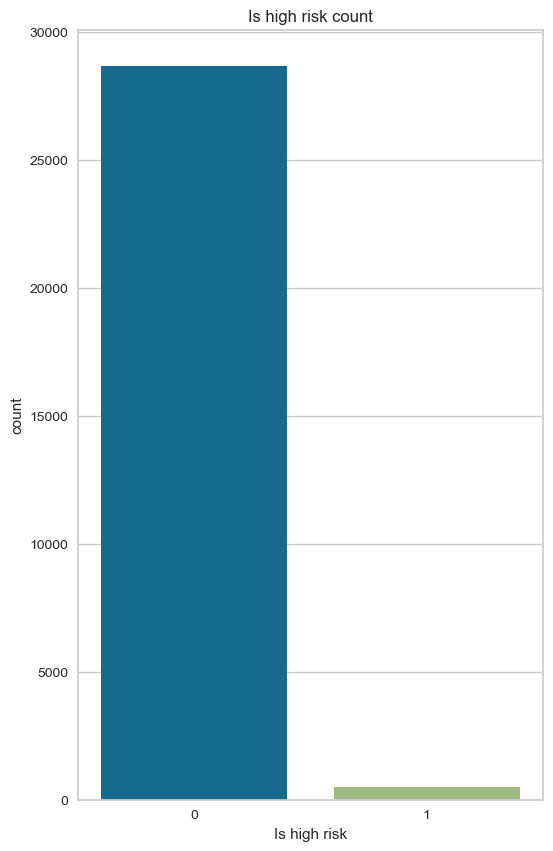

In [ ]:
create_bar_plot(cc_train_copy, "Is high risk")

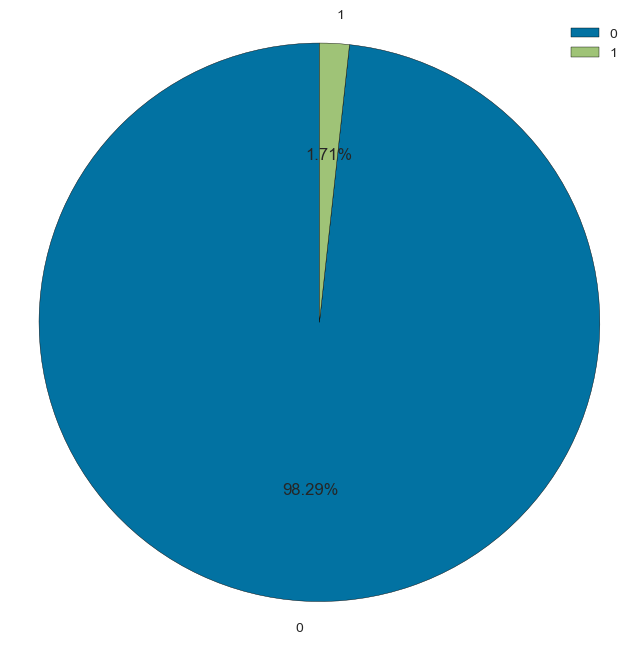

In [ ]:
create_pie_plot(cc_train_copy,"Is high risk")


Vast majority are low risk applicants <br>
0: No<br>
1: Yes

# Bivariate analysis

## Numerical vs numerical features(Correlation and scatter plots)

### scatter plots

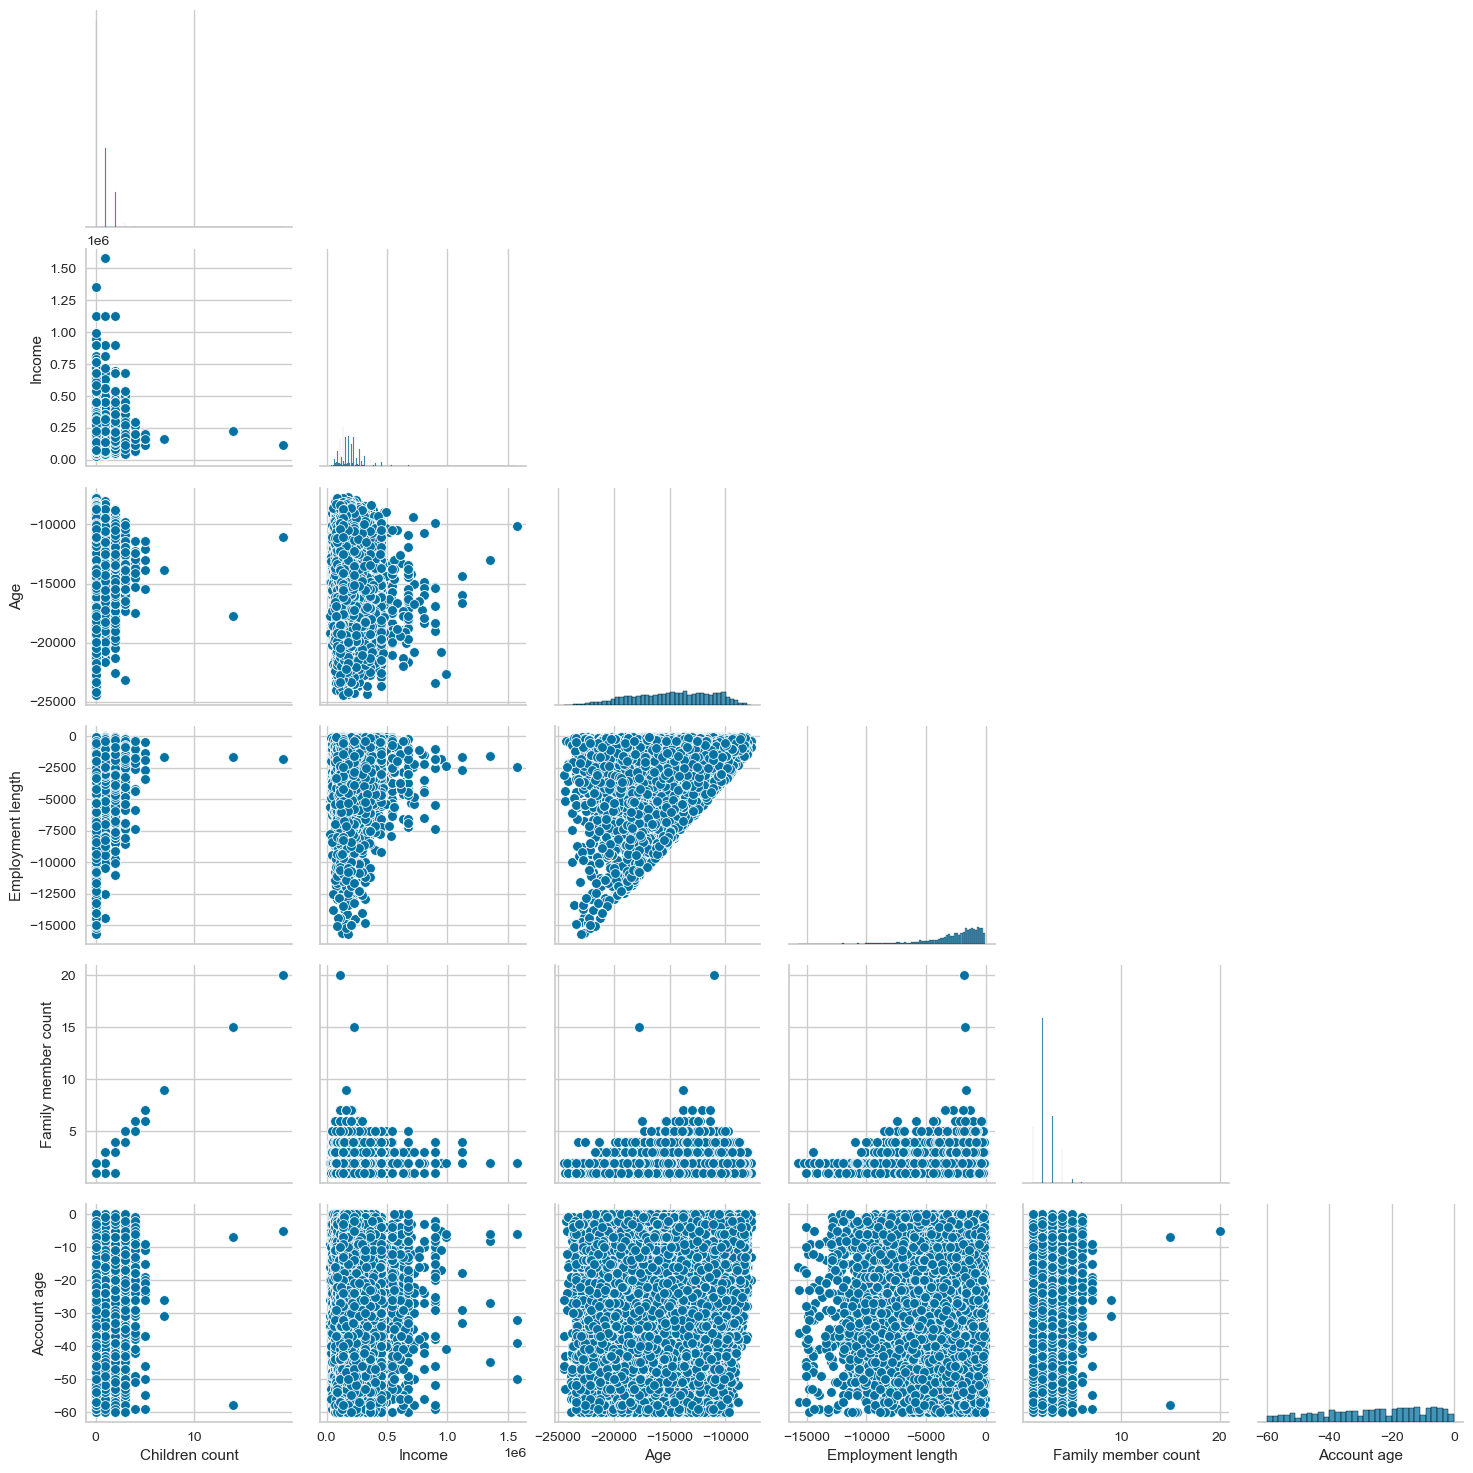

In [ ]:
sns.pairplot(cc_train_copy[cc_train_copy['Employment length']<0].drop(['ID', 'Has a phone', "Has a work phone", 'Has a mobile phone','Has an email', "Is high risk"]
                                                                      , axis=1),
             corner= True
            )
plt.show()

Interpretation:
- A positive correlation between the number of family members and the number of children means that as the number of children increases, the number of family members also increases
- Similarly, a positive correlation between the age and employment length means that as age increases, the length of employment is expected to inceease as well. 

<AxesSubplot:xlabel='Children count', ylabel='Family member count'>

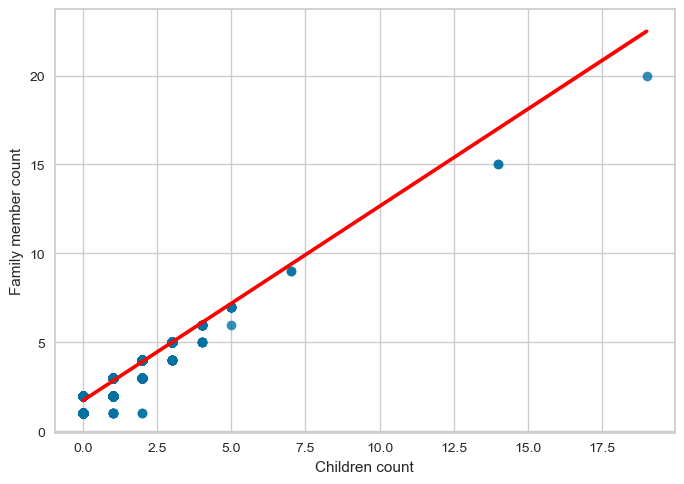

In [ ]:
sns.regplot(x= 'Children count', y= 'Family member count', data= cc_train_copy, line_kws= {'color': 'red'})

In this case, it is stated that the number of family members is directly proportional to the number of children. This means that as the number of children increases, the number of family members is expected to increase as well.



### Account age vs age 

/Users/arunaacharya/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


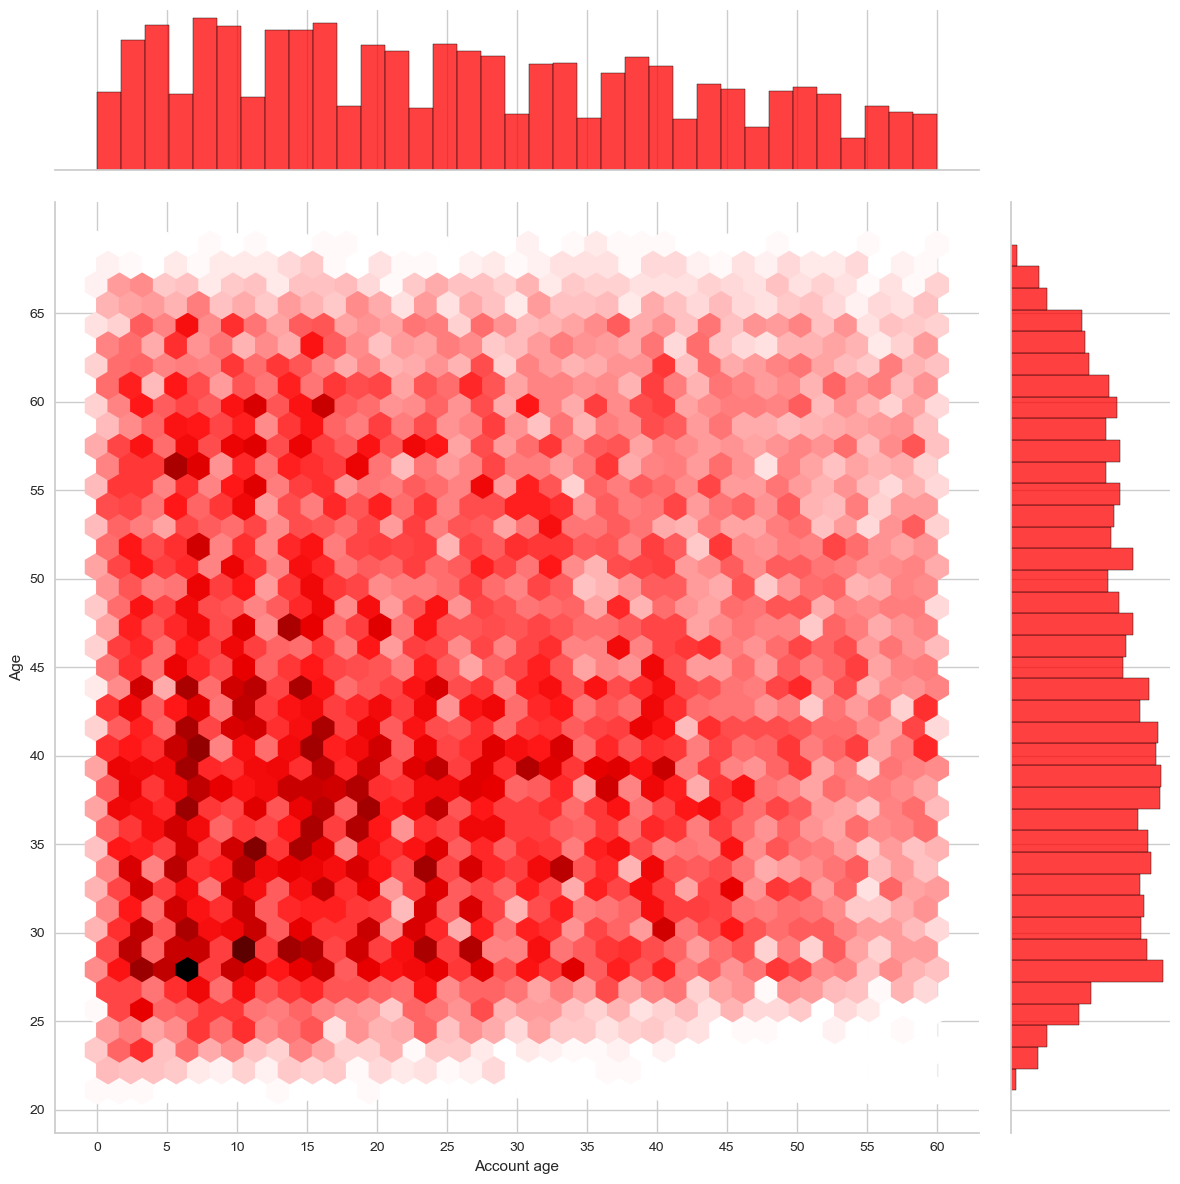

In [ ]:
y_age= np.abs(cc_train_copy['Age'])/365.25
sns.jointplot(np.abs(cc_train_copy['Account age']), y_age, kind= 'hex', color='red',height= 12)
plt.yticks(np.arange(20, y_age.max(),5))
plt.xticks(np.arange(0,65,5))
plt.ylabel('Age')
plt.show()

- Majority of the applicants are age between 25 to 45 and their account is less thatn 25 months old

### Employment length vs age

/Users/arunaacharya/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


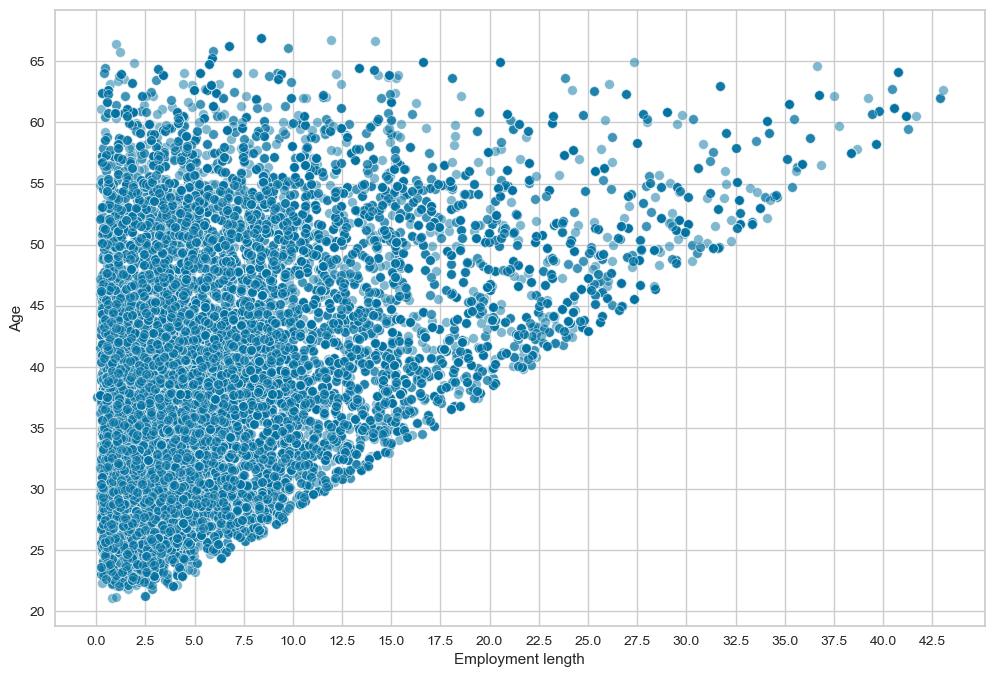

In [ ]:
x_employ_length= np.abs(cc_train_copy[cc_train_copy['Employment length']<0]['Employment length'])/365.25
fig, ax= plt.subplots(figsize= (12, 8))
sns.scatterplot(x_employ_length, y_age, alpha= 0.5)
plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
plt.show()

We can see the positive correlation between Age and Employment length. Applicants who are older has longer employment length 

# Correlation analysis

In [ ]:
cc_train_copy.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5037048      M         Y              Y               0  135000.0   
1  5044630      F         Y              N               1  135000.0   
2  5079079      F         N              Y               2  180000.0   
3  5112872      F         Y              Y               0  360000.0   
4  5105858      F         N              N               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working  Secondary / secondary special               Married   
1  Commercial associate               Higher education  Single / not married   
2  Commercial associate  Secondary / secondary special               Married   
3  Commercial associate               Higher education  Single / not married   
4               Working  Secondary / secondary special             Separated   

            Dwelling    Age  Employment length  Has a mobile phone  \
0       With parents -16271              -3111                   1   
1  House / apartment -10130              -1651                   1   
2  House / apartment -12821              -5657                   1   
3  House / apartment -20929              -2046                   1   
4  House / apartment -16207               -515                   1   

   Has a work phone  Has a phone  Has an email    Job title  \
0                 0            0             0   Core staff   
1                 0            0             0  Accountants   
2                 0            0             0     Laborers   
3                 0            0             1     Managers   
4                 0            1             0          NaN   

   Family member count  Account age Is high risk  
0                  2.0        -17.0            0  
1                  2.0         -1.0            0  
2                  4.0        -38.0            0  
3                  1.0        -11.0            0  
4                  1.0        -41.0            0

In [ ]:
#change the data type of target feature to int
is_high_risk= cc_train_copy['Is high risk'].astype('int32')
is_high_risk.head()

0    0
1    0
2    0
3    0
4    0
Name: Is high risk, dtype: int32

(11, 11)


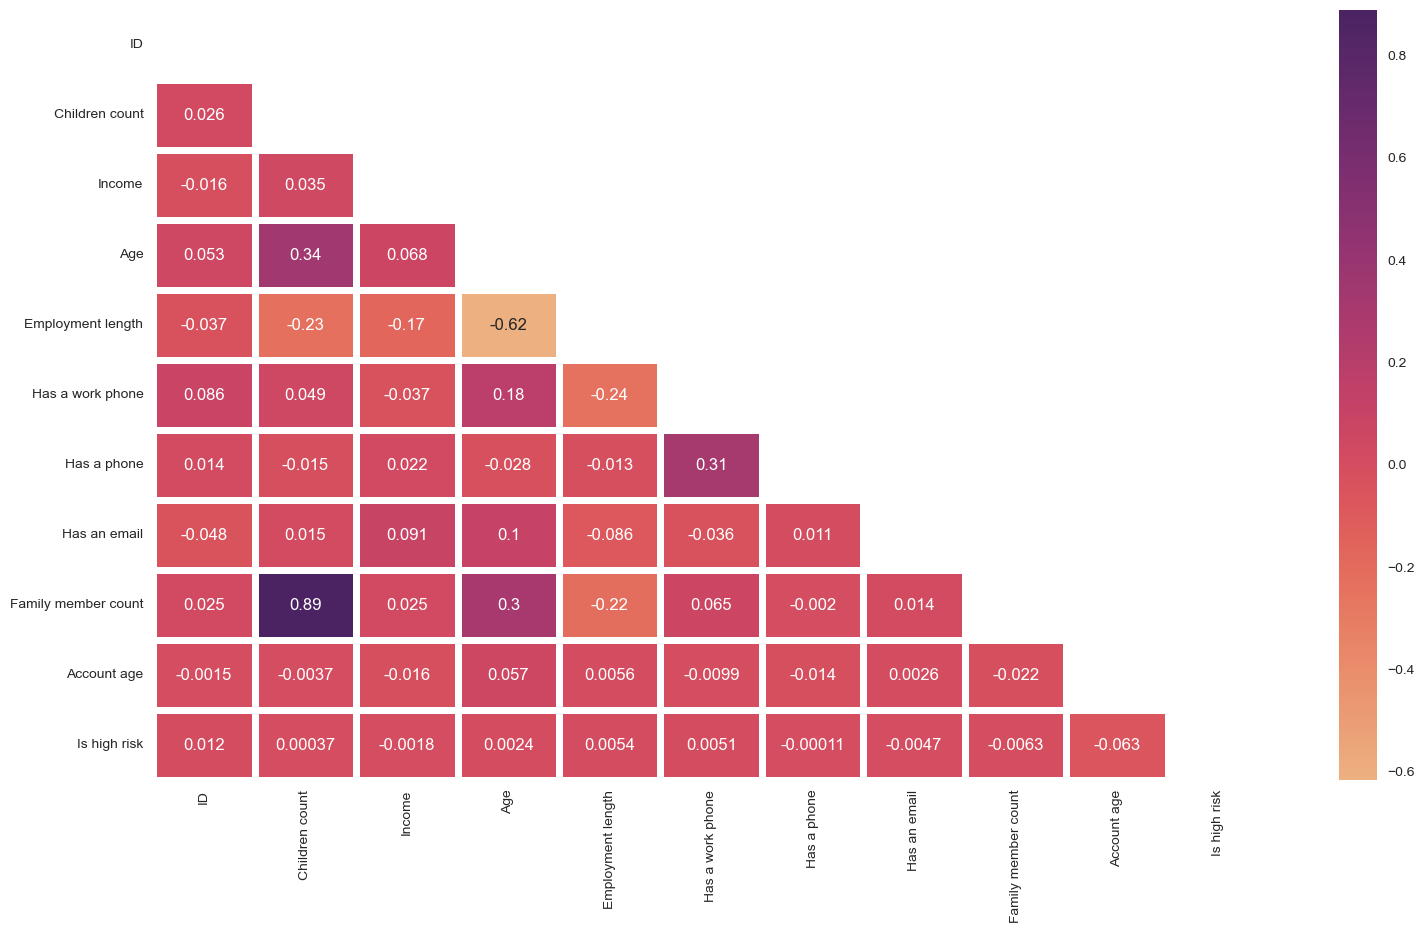

In [ ]:
# correlation analysis with heatmap, after dropping the has a mobile phone with the target feature as int
cc_train_copy_corr_no_mobile= pd.concat([cc_train_copy.drop(['Has a mobile phone', 'Is high risk'], axis= 1,), is_high_risk], axis= 1).corr()
print(cc_train_copy_corr_no_mobile.shape)
# get the lower triangle of the correlation matrix
# generate a mask for the upper triangle
mask= np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)]= True
#setup the matplotlib figure
fig, ax= plt.subplots(figsize=(18,10))
#seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot= True, cmap= "flare", mask= mask ,linewidths= 5)
plt.show()


Interpretation:
- No feature are correlated with the target feature: Is high risk
- As discussed before family member count is highly correlated with children count 
- Negative correlation between employment length and age 

# Numerical vs categorical features

### Age vs the rest of categorical features

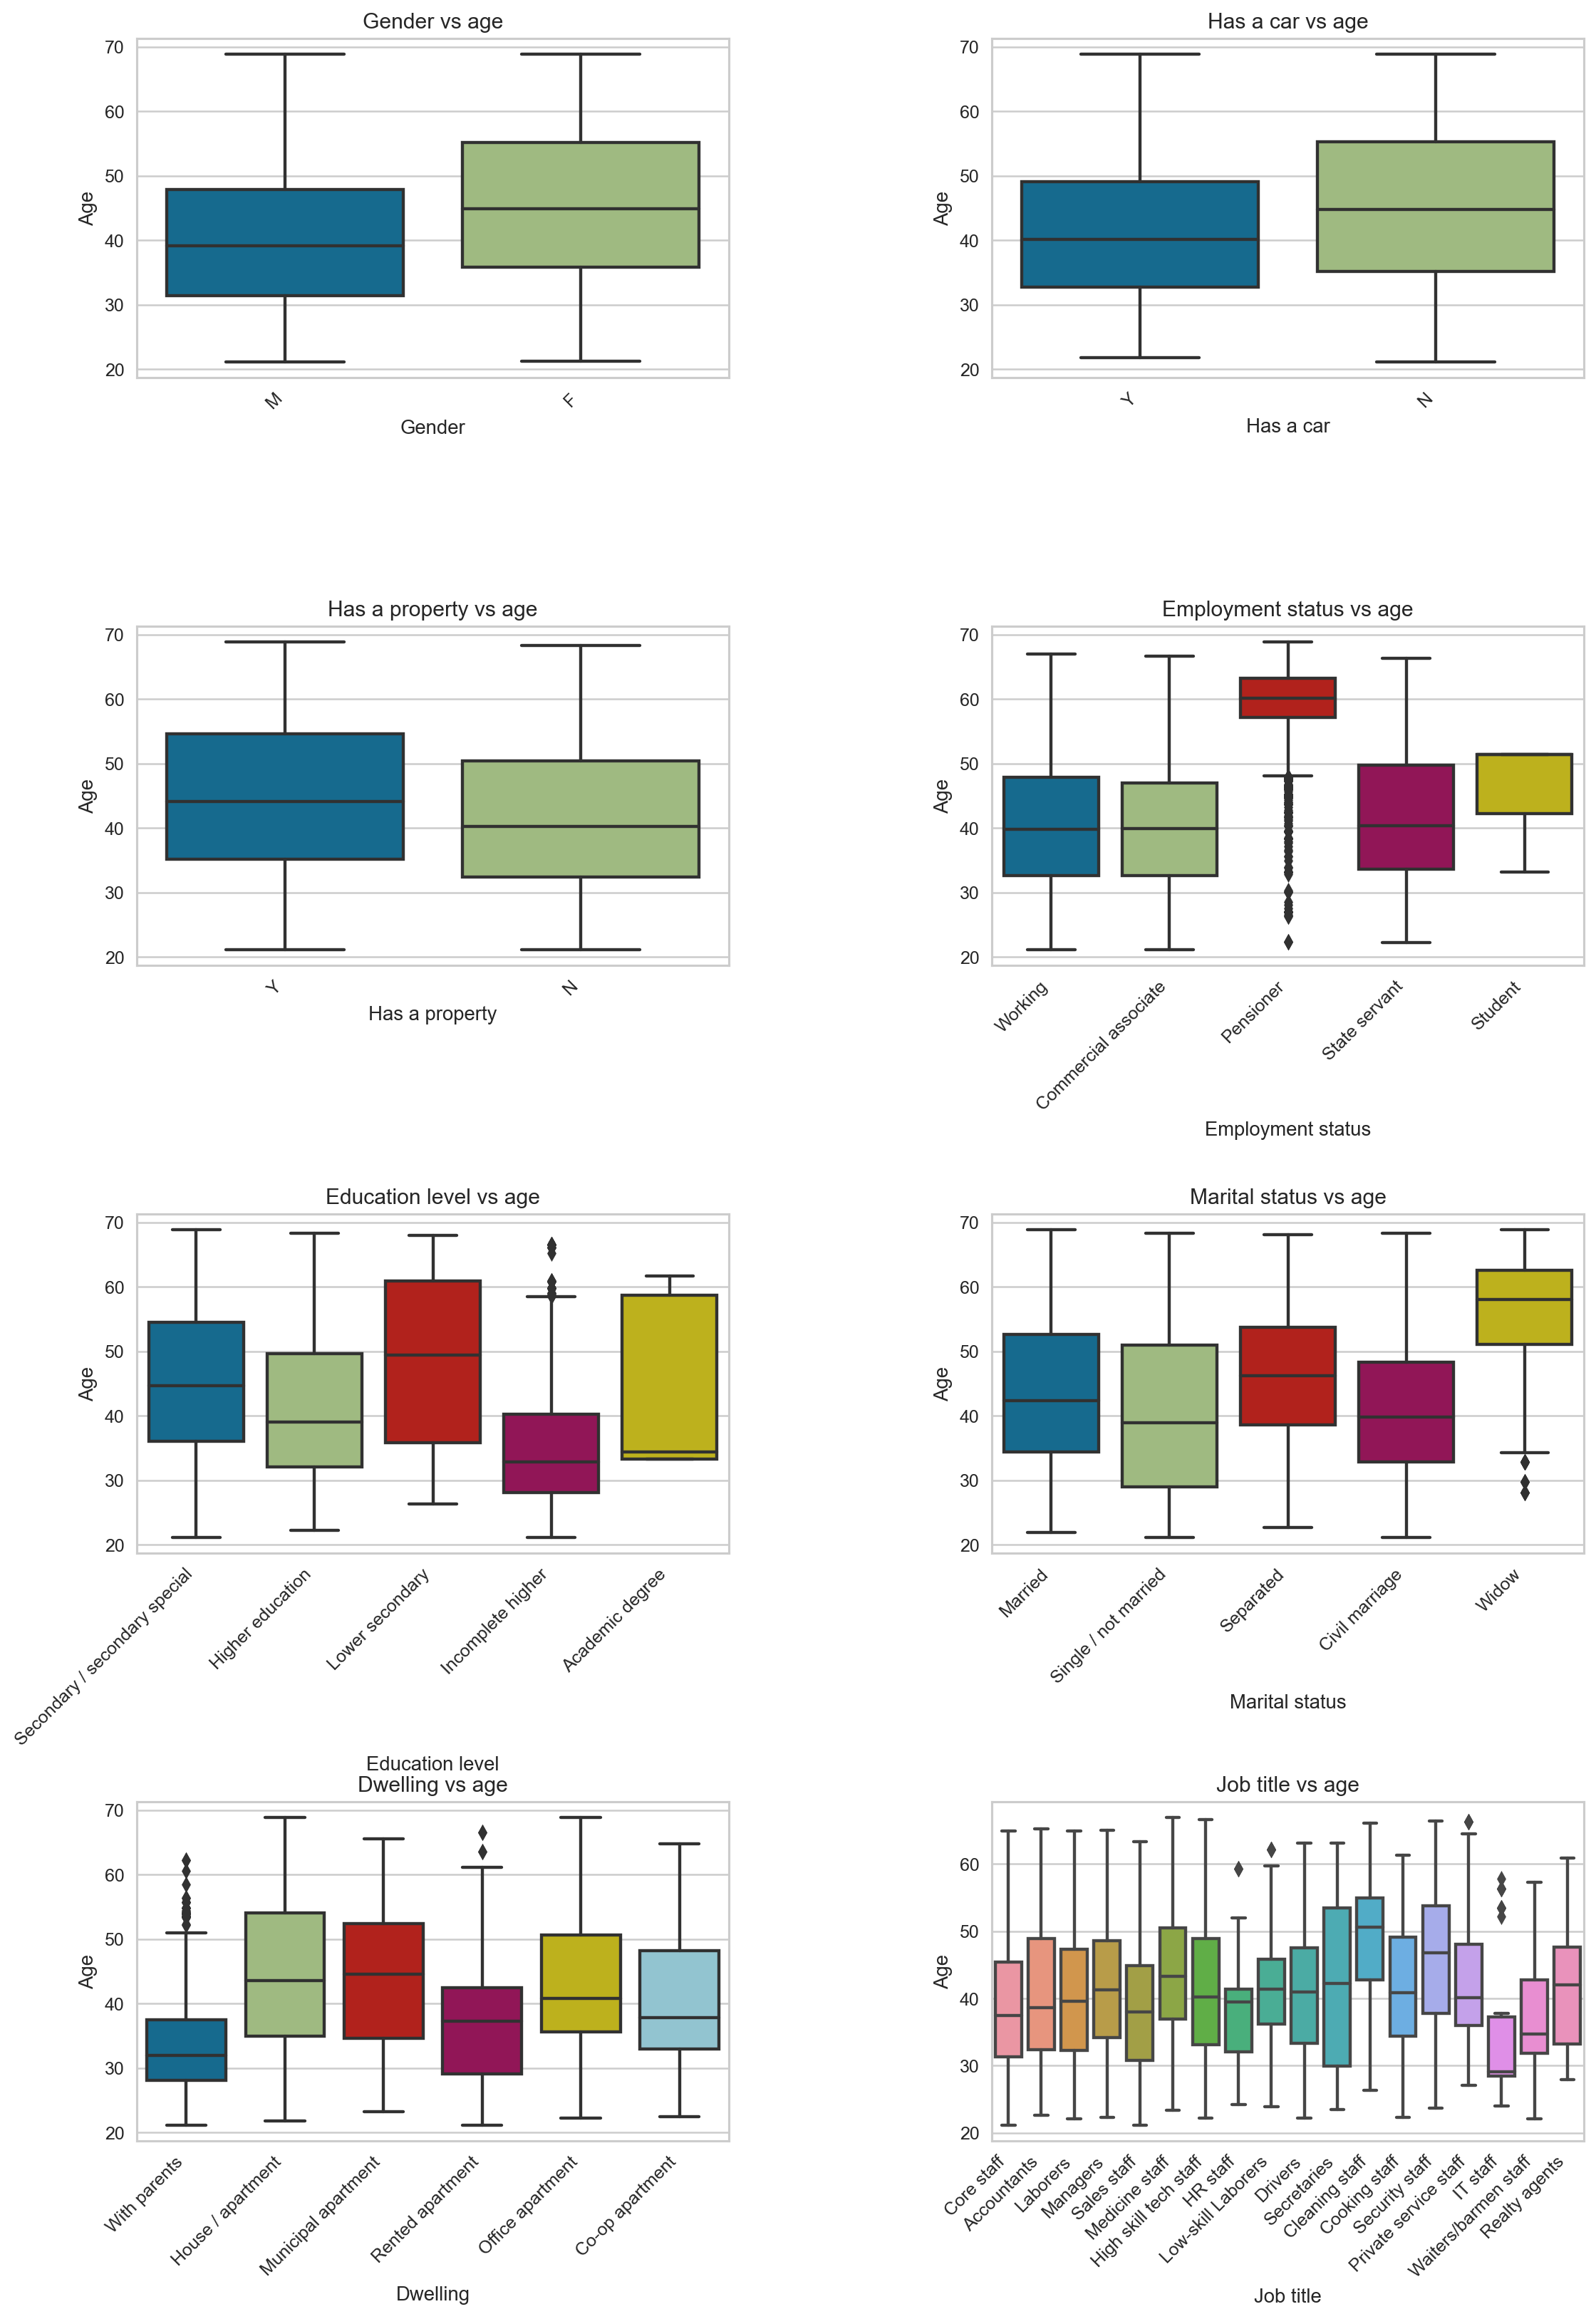

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=10.0)
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count]
                        ,x=cc_train_copy[cat_features[cat_ft_count]],
                        y=np.abs(cc_train_copy['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

# Employment length vs the rest of categorical features

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


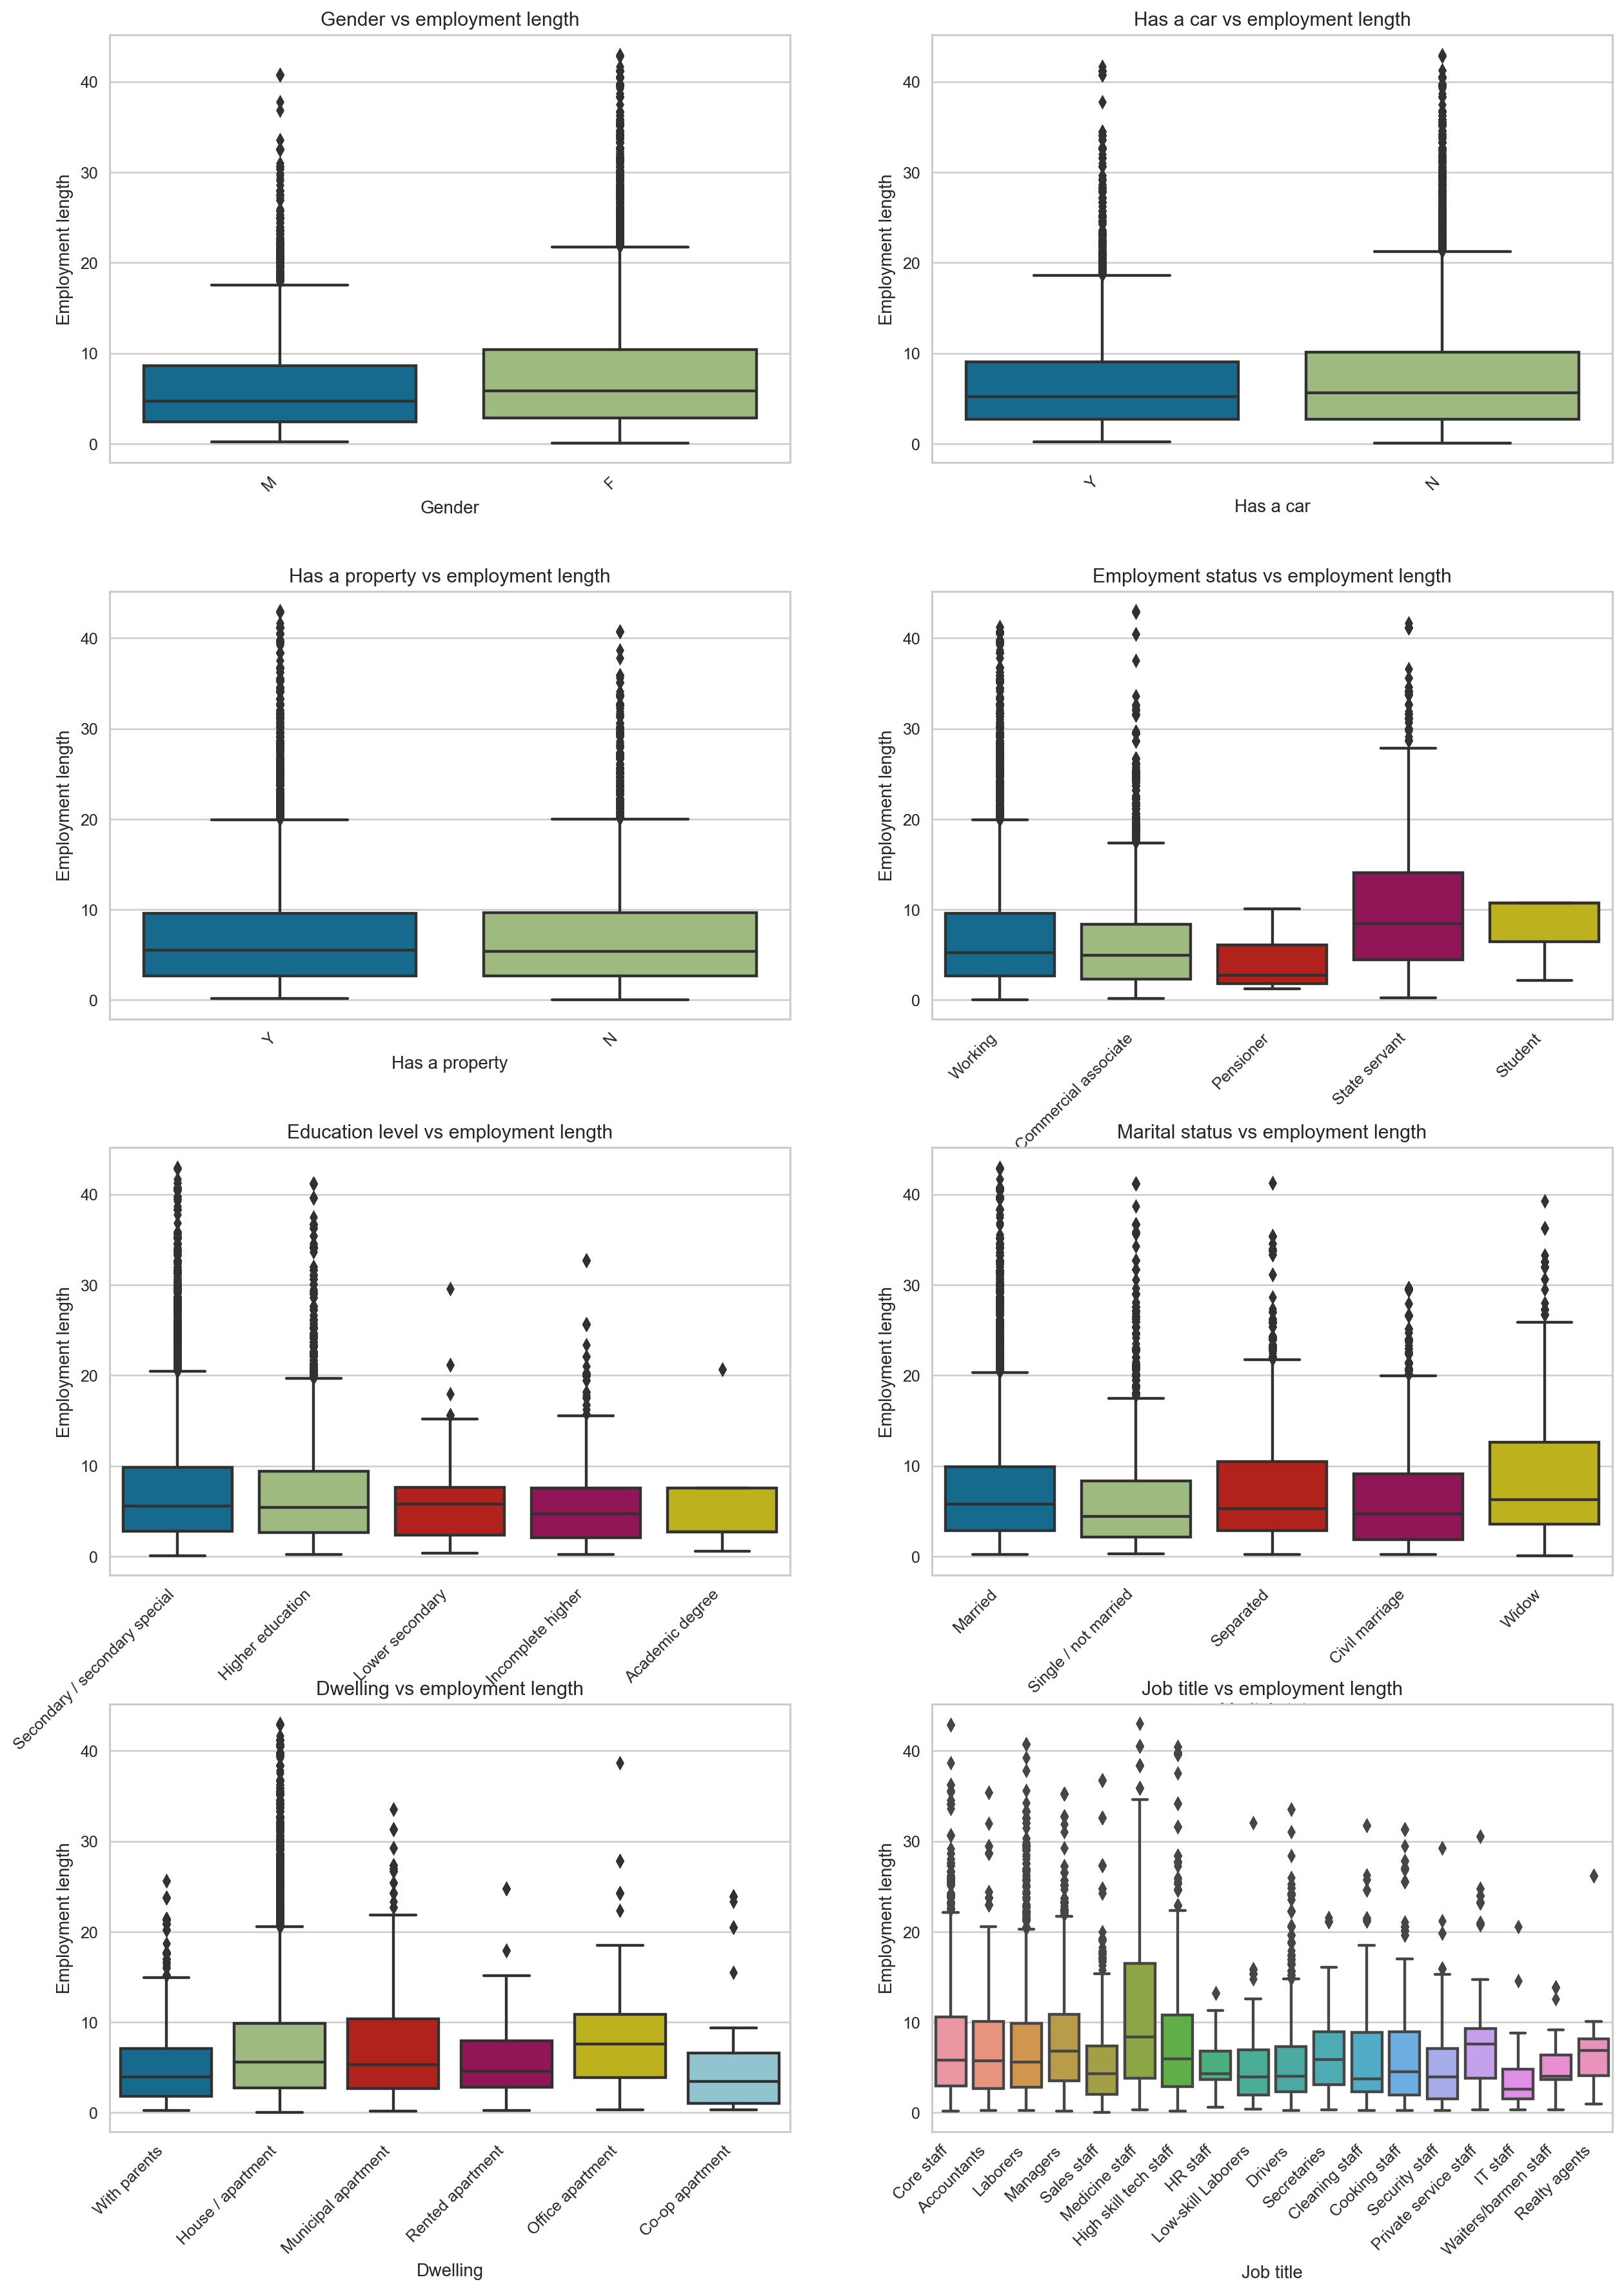

In [ ]:
fig, axes= plt.subplots(4,2, figsize = (15,20), dpi= 180)
fig.tight_layout(pad= 5.0)
print(axes)
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):            
            sns.boxplot(ax= axes[row_count, feat_count], 
                       x= cc_train_copy[cat_features[cat_ft_count]],
                       y= np.abs(cc_train_copy[cc_train_copy['Employment length']<0]['Employment length'])/365.25)
            axes[row_count, feat_count].set_title(cat_features[cat_ft_count]+" vs employment length")
            plt.sca(axes[row_count, feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation= 45, ha='right')
            cat_ft_count +=1
    break

### Income vs other categorical features

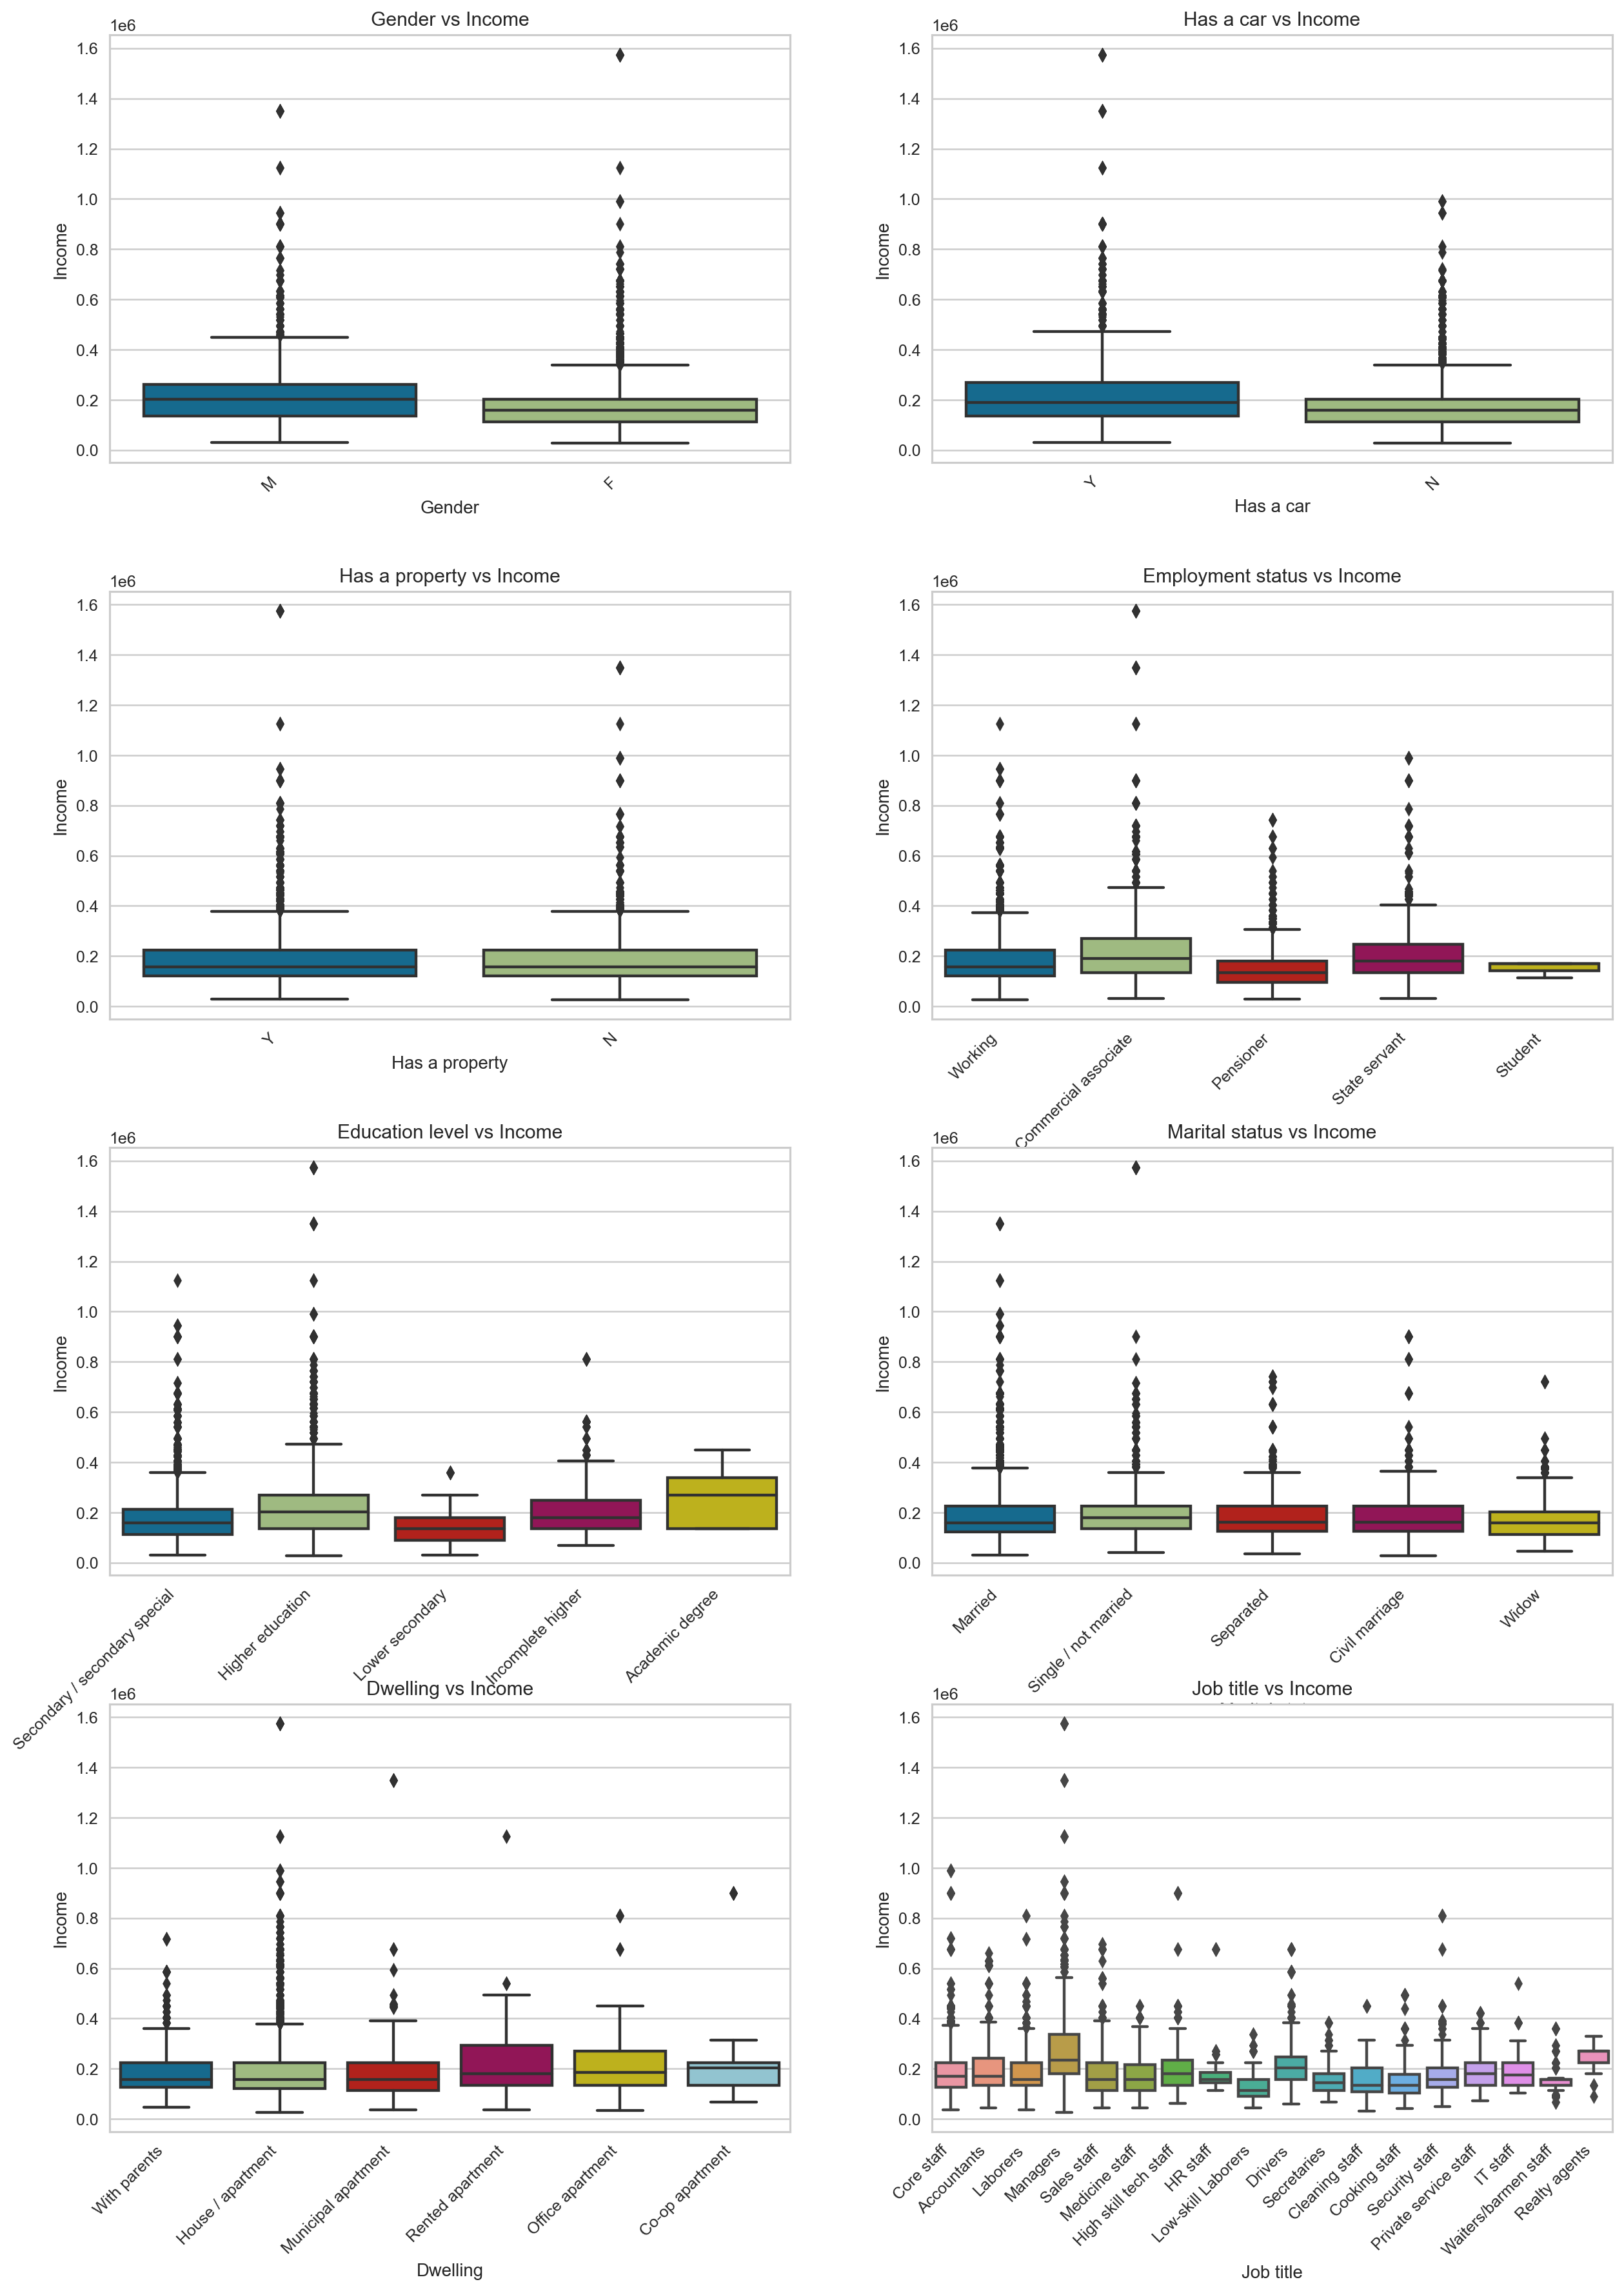

In [ ]:
fig, axes= plt.subplots(4,2, figsize = (15,20), dpi= 180)
fig.tight_layout(pad= 5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):            
            sns.boxplot(ax= axes[row_count, feat_count], 
                       x= cc_train_copy[cat_features[cat_ft_count]],
                       y= cc_train_copy['Income']
                       )                        
            axes[row_count, feat_count].set_title(cat_features[cat_ft_count]+" vs Income")
            plt.sca(axes[row_count, feat_count])
            plt.ylabel('Income')
            plt.xticks(rotation= 45, ha='right')
            cat_ft_count +=1
    break

# Categorical vs categorical features (Chi-square test)

In [ ]:
def chi_func(feature):
    #selection row with high risk
    high_risk_ft= cc_train_copy[cc_train_copy['Is high risk']==1][feature]
    high_risk_ft_ct= pd.crosstab(index= high_risk_ft, columns= ['Count']).rename_axis(None, axis= 1)
    #drop the index feature name
    high_risk_ft_ct.index.name= None
    obs= high_risk_ft_ct
    print('Observed value: \n')
    print(obs)
    print('\n')
    #expected value
    print(obs.index)
    exp= pd.DataFrame([obs['Count'].sum()/len(obs)]*len(obs.index),columns= ['Count'],index= obs.index)
    print('Expected values: \n')
    print(exp)
    print('\n')
    chi_squared_stat= (((obs-exp)**2)/exp).sum()
    print('Chi-square: \n')
    print(chi_squared_stat[0])
    print('\n')
    #critical value
    crit= chi2.ppf(q= 0.95, df= len(obs)-1)
    print('Critical value: \n')
    print(crit)
    print('\n')
    p_value= 1- chi2.cdf(x= chi_squared_stat, df = len(obs)-1)
    print("P value : \n")
    print(p_value)
    print("\n")
    if chi_squared_stat[0]>= crit:
        print('\033[1m' + 'Reject the null hypothesis' + '\033[0m')
    elif chi_squared_stat[0]<= crit:
        
        print('\033[1m'+ 'Fail to reject the null hypothesis'+ '\033[1m')

In [ ]:
cat_ft= ['Gender','Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for ft in cat_ft:
    print (f" **********************************************************  {ft}  ***************************************************************\n\n")
    
    chi_func(ft)

 **********************************************************  Gender  ***************************************************************


Observed value: 

   Count
F    306
M    193


Index(['F', 'M'], dtype='object')
Expected values: 

   Count
F  249.5
M  249.5


Chi-square: 

25.589178356713425


Critical value: 

3.841458820694124


P value : 

[4.22401699e-07]


Reject the null hypothesis
 **********************************************************  Has a car  ***************************************************************


Observed value: 

   Count
N    317
Y    182


Index(['N', 'Y'], dtype='object')
Expected values: 

   Count
N  249.5
Y  249.5


Chi-square: 

36.523046092184366


Critical value: 

3.841458820694124


P value : 

[1.50871859e-09]


Reject the null hypothesis
 **********************************************************  Has a property  ***************************************************************


Observed value: 

   Count
N    210
Y    289


Index(['N', 'Y'],

## Business Findings 
- Majority of the applicants are aged between 25 to 45 years old and have an account that is 25 months old or less
- A vast majority of the applicants are low risk applicants but those who are at higher risk has short employment length and has older accounts


# Prepare the data


## Transform to be done on each feature


ID
- Drop the feature

Gender: 
- One hot encoding(categorical variables is converted to binary vectors, where each category is represented as a seperate feature)

Age: 
- Min- mx scaling
- Fix skewness
- Abs value and div 365.25

Mrital status:
- one hot encoding

Family member count:
- Fix outliers

Children Count:
- Fix outliers
- drop feature

Dwelling type: 
- One hot encoding

Income:
- Remove outliers
- Fix skewness
- Min-max scaling

Job title:
- One hot encoding
- Impute missing values

Employment status:
- One hot encoding

Education level:
- Ordinal encoding(each unique category in categorical variable is assigned a numeric value based on its order or rank)

Employment length:
- Remove outliers
- Min-max scaling
- abs value and div 365.25
- change days of employments of retirees to 0 

Has a car:
- one hot encoding

Has a property:
- One hot encoding

Has a mobile phone:
- Drop feature

Has a work phone:
- one hot encoding 

Has an email: 
- one hot encoding

Account age: 
- Drop feature

Is high risk(Target):
- Change the data type to numerical 
- balance the data with SMOTE(Synthetic Minority Over-smapling Technique: Creates synthetic examples of the minrity class to balance the class distribution and improve the performance of machine learning algorithms on imbalanced datasets)



# Data Cleaning 


## Outliers handling


In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers= ['Family member count', 'Income', 'Employment length']):
        self.feat_with_outliers= feat_with_outliers
        
    def fit(self, df):
        return self
    
    def transform(self, df):
        if (set(self.feat_with_outliers). issubset(df.columns)):
            #25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            
            #75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            
            #keep the dta within 3 IQR
            df= df[~((df[self.feat_with_outliers]< (Q1 - 3 * IQR)) | (df[self.feat_with_outliers]> (Q3 + 3 * IQR))). any (axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

# Feature selection


## Drop features

Reason to drop these tables:
- ID: Id is not useful for prediction, its only use is while merging two datasets
- has a mobile phone: almost everyone has a mobile phone and this feature does not inform about anything
- Children count: Is highly correlated with Family member count, and to avoid multicollineraity, we drop it
- Job title: Has some missing values and the count of each category is not vey different to justify the use of mode
- Accou nt age: Because account was used to create the target, reusing will make our model to overfit. Plus this information is unknows while applying for a credicard
    

In [ ]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## Time Conversion

In [ ]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # convert days to absolute value
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X


# Retiree handling (in the employment length feature)

In [ ]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

## Skewness handling <p>(correcting the asymmetry in a dataset to improve statistical analysis and machine learning model performance)</p>

In [ ]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

# Binning

In [ ]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## One hot encoding (with features name)

In [ ]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df
                

## Ordinal encoding (with feature's names)

In [ ]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

# Min-Max scaling (with feature's names)

In [ ]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## Change the data types of the target feature


In [ ]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

## Oversampling


In [ ]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

We are oversampling with SMOTE because the minority class (Is high risk = 1) is very rare in the data


## Data PreProcessing

In [ ]:
def full_pipeline(df):
    # Create the pipeline that will call all the class from OutlierRemoval to OversampleSMOTE in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [ ]:
cc_train_prep = full_pipeline(cc_train_copy)

In [ ]:
pd.set_option('display.max_columns', None)
cc_train_prep.head()

Gender_F  Gender_M  Marital status_Civil marriage  Marital status_Married  \
0       0.0       1.0                            0.0                     1.0   
1       1.0       0.0                            0.0                     0.0   
2       1.0       0.0                            0.0                     1.0   
3       1.0       0.0                            0.0                     0.0   
4       1.0       0.0                            0.0                     0.0   

   Marital status_Separated  Marital status_Single / not married  \
0                       0.0                                  0.0   
1                       0.0                                  1.0   
2                       0.0                                  0.0   
3                       0.0                                  1.0   
4                       1.0                                  0.0   

   Marital status_Widow  Dwelling_Co-op apartment  Dwelling_House / apartment  \
0                   0.0                       0.0                         0.0   
1                   0.0                       0.0                         1.0   
2                   0.0                       0.0                         1.0   
3                   0.0                       0.0                         1.0   
4                   0.0                       0.0                         1.0   

   Dwelling_Municipal apartment  Dwelling_Office apartment  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   

   Dwelling_Rented apartment  Dwelling_With parents  \
0                        0.0                    1.0   
1                        0.0                    0.0   
2                        0.0                    0.0   
3                        0.0                    0.0   
4                        0.0                    0.0   

   Employment status_Commercial associate  Employment status_Pensioner  \
0                                     0.0                          0.0   
1                                     1.0                          0.0   
2                                     1.0                          0.0   
3                                     1.0                          0.0   
4                                     0.0                          0.0   

   Employment status_State servant  Employment status_Student  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              0.0                        0.0   
4                              0.0                        0.0   

   Employment status_Working  Has a car_N  Has a car_Y  Has a property_N  \
0                        1.0          0.0          1.0               0.0   
1                        0.0          0.0          1.0               1.0   
2                        0.0          1.0          0.0               0.0   
3                        0.0          0.0          1.0               0.0   
4                        1.0          1.0          0.0               1.0   

   Has a property_Y  Has a work phone_N  Has a work phone_Y  Has a phone_N  \
0               1.0                 1.0                 0.0            1.0   
1               0.0                 1.0                 0.0            1.0   
2               1.0                 1.0                 0.0            1.0   
3               1.0                 1.0                 0.0            1.0   
4               0.0                 1.0                 0.0            0.0   

   Has a phone_Y  Has an email_N  Has an email_Y    Income  Education level  \
0            0.0             1.0             0.0  0.417817              4.0   
1 

In [ ]:
cc_train_prep.shape

(46544, 34)

In [ ]:
#split the train data into X and Y (target)
X_cc_train_prep, y_cc_train_prep = cc_train_prep.loc[:, cc_train_prep.columns != 'Is high risk'], cc_train_prep['Is high risk'].astype('int64')

# Short-list promising models

## Model Training

In [ ]:
classifiers = {
    'sgd': SGDClassifier(random_state= 42,loss= 'perceptron'),
    'logistic_regression': LogisticRegression(random_state= 42, max_iter= 1000),
    'decision_tree':DecisionTreeClassifier(random_state= 42),
    'random_forest':RandomForestClassifier(random_state= 42),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state= 42),
    'linear_discriminaant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state= 42),
    'neural_network':MLPClassifier(random_state= 42, max_iter= 100),
    'adaboost':AdaBoostClassifier(random_state= 42),
    'extra_trees':ExtraTreesClassifier(random_state= 42),
}

In [ ]:
#function to get the feature importance of the classifier, and plot it
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd', 'support_vector_machine', 'gaussian_naive_bayes', 'k_nearest_neighbors' ,'bagging','neural_network']:
        plt.rcParams['xtick.labelsize']= 12
        plt.rcParams['ytick.labelsize']= 12
        top_10_feat = FeatureImportances(model_trn, relative= False, topn=10)
        bottom_10_feat= FeatureImportances(model_trn, relative= False, topn= 10)
        plt.figure(figsize= (10,4))
        plt.xlabel('xlabel', fontsize= 14)
        top_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        top_10_feat.show()
        print('\n')
        plt.figure(figsize= (10,4))
        plt.xlabel('xlabel', fontsize= 14)
        #Fit to get the feature importances
        bottom_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        bottom_10_feat.show()
        print('\n')
    else:
        print ('No feature importance for {0}'.format(model_name))
        print('\n')
            

In [ ]:

def y_prediction_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
        try:
            y_cc_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
            return y_cc_train_pred
        else:
            # if it exist load the predictions
            y_cc_train_pred = joblib.load(y_cc_train_pred_path)
            return y_cc_train_pred
    else:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(model_name))
        try:
            y_cc_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred_final = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred_final,y_cc_train_pred_path_final)
            return y_cc_train_pred_final
        else:
            # if it exist load the predictions
            y_cc_train_pred_final = joblib.load(y_cc_train_pred_path_final)
            return y_cc_train_pred_final


### Confusion Matrix Plot


In [ ]:
#Function to plot the confusion matrix
def confusion_matrix_func(model_trn, model_name, final_model= False):
    if final_model == False:
        fig, ax= plt.subplots(figsize= (8,8))
        #plot confusion matrix
        conf_matrix= ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,
                                                            y_prediction_func(model_trn, model_name),
                                                            ax= ax,
                                                            cmap= 'Blues',
                                                            values_format='d',)
        plt.grid(visible= None)
        plt.xlabel('Predicted Label', fontsize = 14)
        plt.ylabel('True Label', fontsize= 14)
        plt.title('Confusion Matrix', fontsize= 14)
        plt.show()
        print('\n')
    else:
        fig, ax= plt.subplots(figsize= (8,8))
        conf_matrix_final= ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,
                                                                  y_prediction_func(model_trn, model_name, final_model= True),
                                                                  ax= ax,
                                                                  cmap= 'Blues',
                                                                  values_format= 'd')
        plt.grid(visible= None)
        plt.xlabel('Predicted Label', fontsize = 14)
        plt.ylabel('True Label', fontsize= 14)
        plt.title('Confusion Matrix', fontsize= 14)
        plt.show()
        print('\n')
                                                            

### Roc Curve Plot

In [ ]:
def roc_curve_func(model_trn, model_name, final_model= False):
    if final_model == False:
        #check if y probabilities file exists, if not create it 
        y_proba_path = Path('saved_models/{0}/y_cc_train_proba_{0}.sav'.format(model_name))
        try:
            y_proba_path.resolve(strict= True)
        except FileNotFoundError:
            y_cc_train_proba= model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba, y_proba_path)
        else:
            #if path exist load the y probabilities file
            y_cc_train_proba = joblib.load(y_proba_path)
        skplt.metrics.plot_roc(y_cc_train_prep, 
                               y_cc_train_proba,
                               title= 'Roc Curve for {0}'.format(model_name),
                               cmap= 'cool',
                               figsize= (8,6),
                               text_fontsize= 'large'
                              )
        plt.grid(visible= None)
        plt.show()
        print('\n')
    else:
        y_proba_path_final = Path('saved_models_final/{0}/y_cc_train_proba_{0}_final.sav'.format(model_name))
        try:
            y_proba_path_final.resolve(strict= True)
        except FileNotFoundError:
            y_cc_train_proba_final = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba_final, y_proba_path_final)
        else:
            y_cc_train_proba_final= joblib.load(y_proba_path_final)
            skplt.metrics.plot_roc(y_cc_train_prep, 
                               y_cc_train_proba_final,
                               title= 'Roc Curve for {0}'.format(model_name),
                               cmap= 'cool',
                               figsize= (8,6),
                               text_fontsize= 'large'
                              )
            plt.grid(visible = None)
            plt.show()
            print('\n')
            
        

In [ ]:
def score_func(model_trn, model_name, final_model= False):
    if final_model == False:
        class_report = classification_report(y_cc_train_prep, y_prediction_func(model_trn, model_name))
        print(class_report)
    else:
        class_report_final= classification_report(y_cc_train_prep, y_prediction_func(model_trn, model_name, final_model= True))
        print(class_report)

In [ ]:
def train_model(model, model_name, final_model=False):
    # if we are not training the final model
    if final_model == False:
        # check if the model file exists and if not create, train and save it
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_name == 'sgd':
                # for sgd, loss = 'hinge' does not have a predict_proba method. Therefore, we use a calibrated model
                calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
                model_trn = calibrated_model.fit(X_cc_train_prep,y_cc_train_prep)
            else:
                model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            model_file_path.parent.mkdir(parents=True, exist_ok=True)
            joblib.dump(model_trn,model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exists, load the model
            model_trn = joblib.load(model_file_path)
            # plot the most and least predictive features
            return model_trn
    else:
        # check if the final model file exists and if not create, train and save it
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(model_name))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            final_model_file_path.parent.mkdir(parents=True, exist_ok=True)
            joblib.dump(model_trn,final_model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exists, load the model
            model_trn = joblib.load(final_model_file_path)
            # plot the most and least predictive features
            return model_trn


In [ ]:
def folder_check_model():
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))
        

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)






----------------------  sgd  ----------------------


              precision    recall  f1-score   support

           0       0.58      0.61      0.59     23272
           1       0.59      0.55      0.57     23272

    accuracy                           0.58     46544
   macro avg       0.58      0.58      0.58     46544
weighted avg       0.58      0.58      0.58     46544



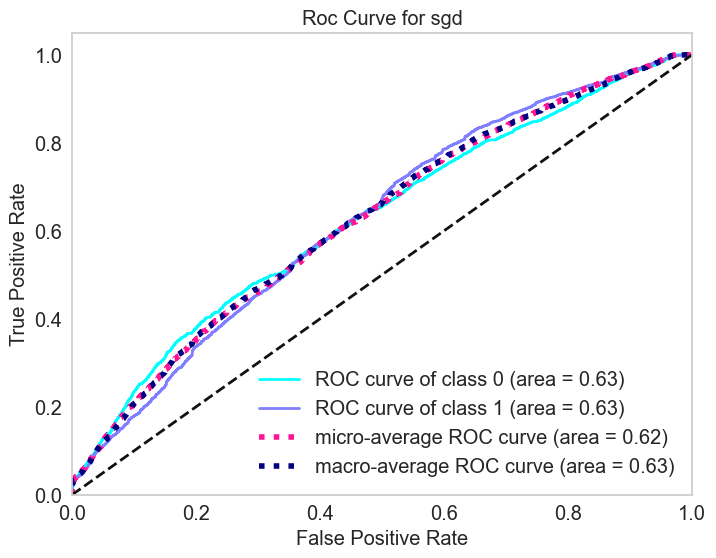

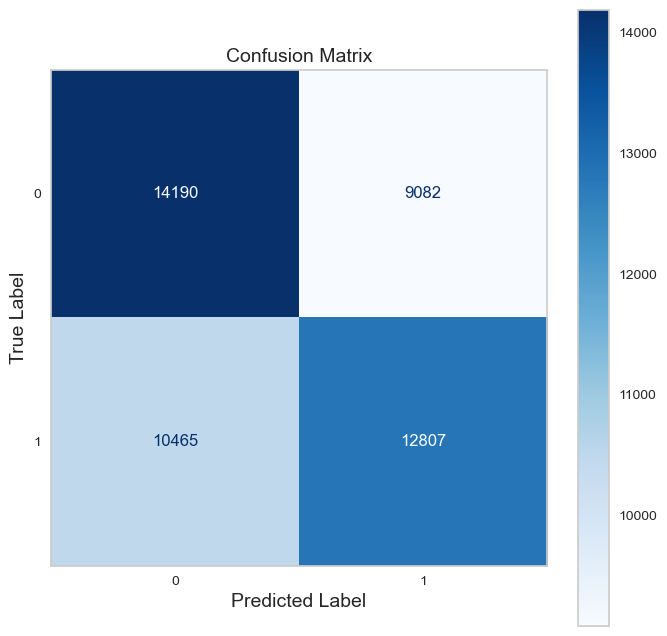



No feature importance for sgd






----------------------  logistic_regression  ----------------------


              precision    recall  f1-score   support

           0       0.60      0.56      0.58     23272
           1       0.59      0.62      0.60     23272

    accuracy                           0.59     46544
   macro avg       0.59      0.59      0.59     46544
weighted avg       0.59      0.59      0.59     46544



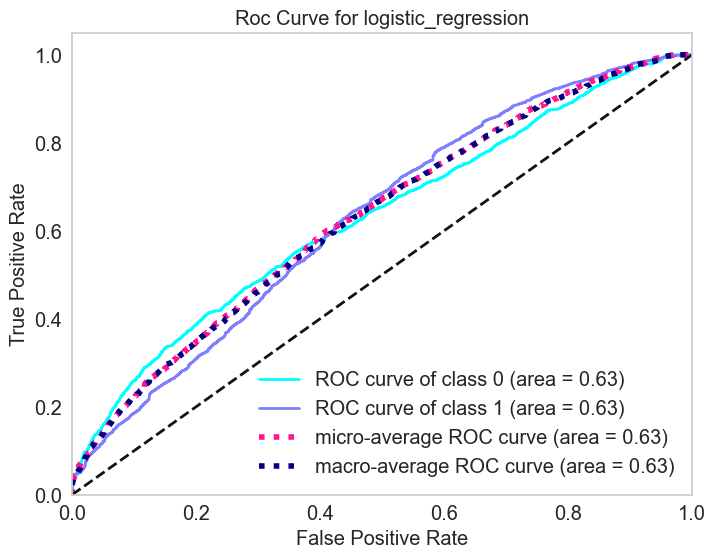

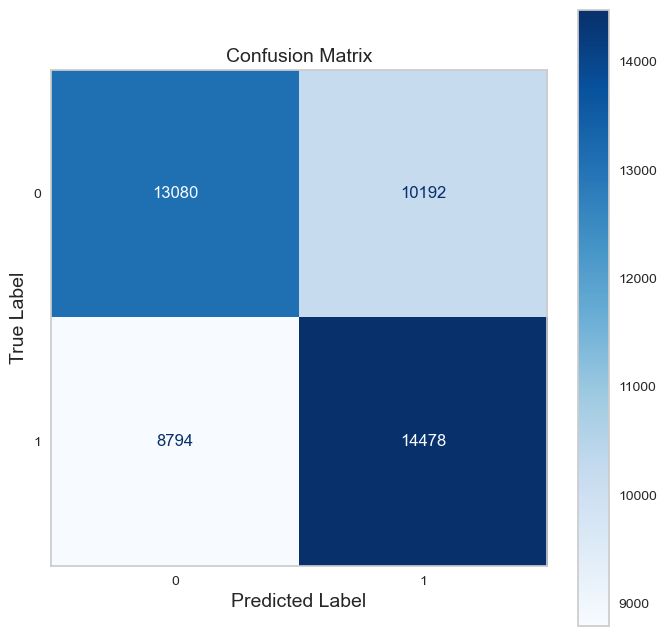

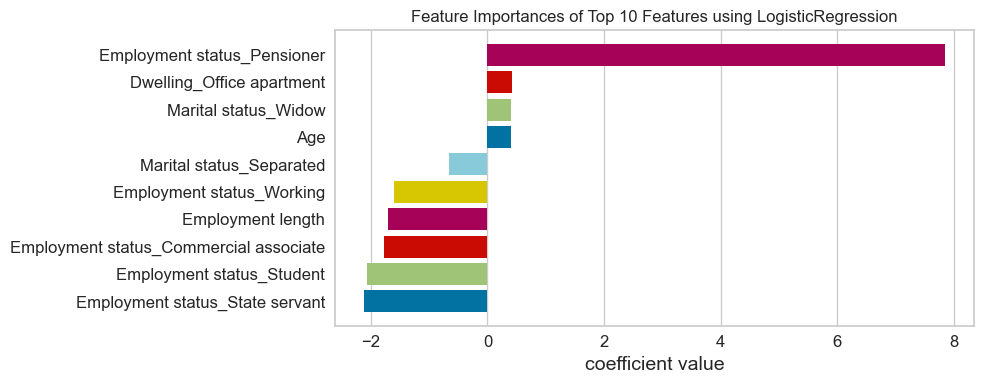

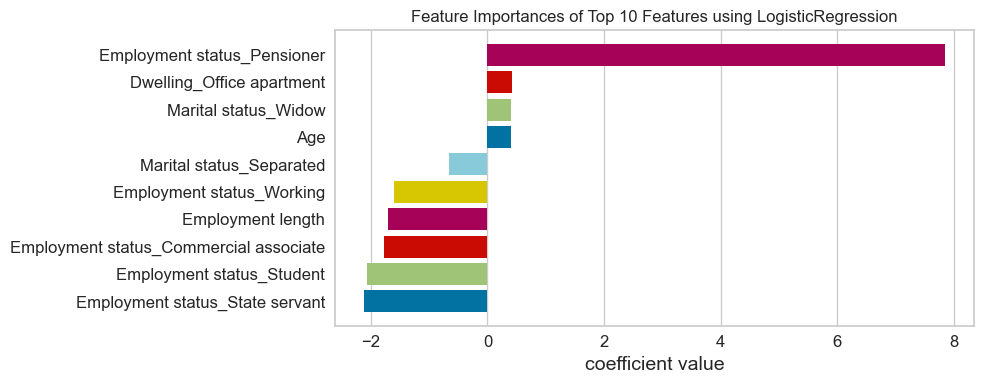







----------------------  decision_tree  ----------------------


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     23272
           1       0.98      0.98      0.98     23272

    accuracy                           0.98     46544
   macro avg       0.98      0.98      0.98     46544
weighted avg       0.98      0.98      0.98     46544



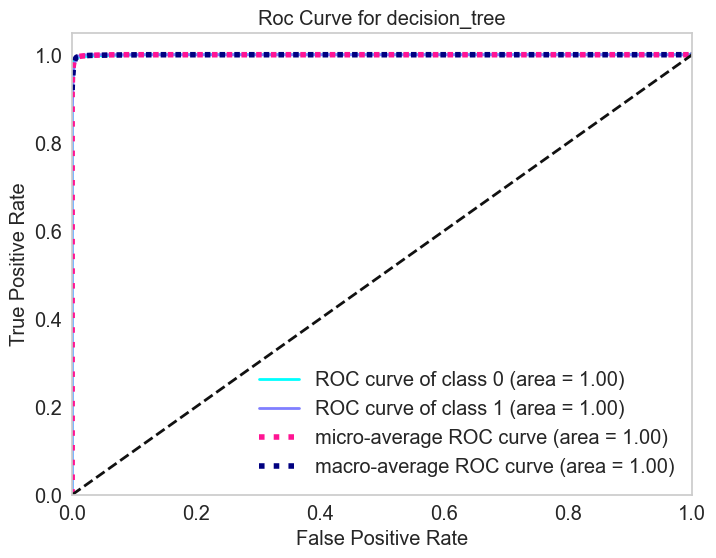

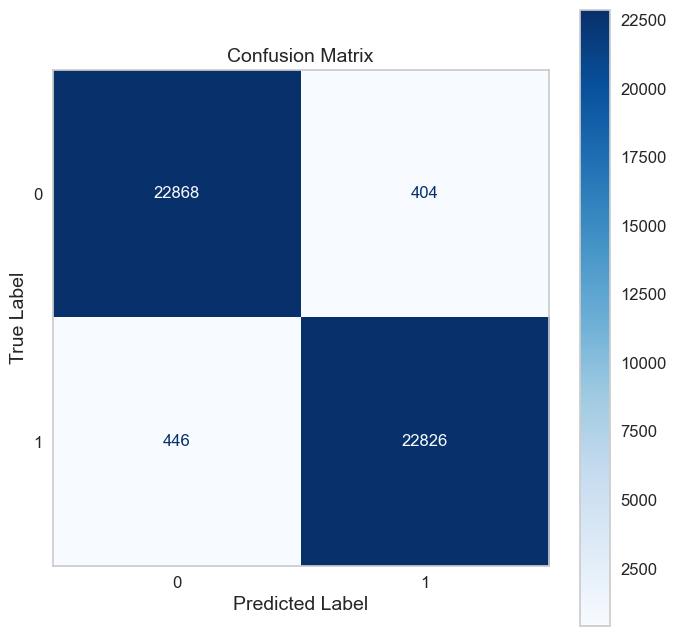

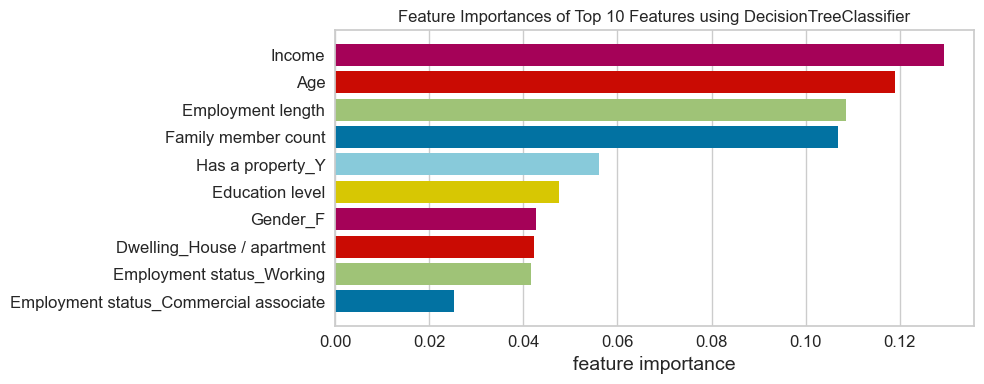

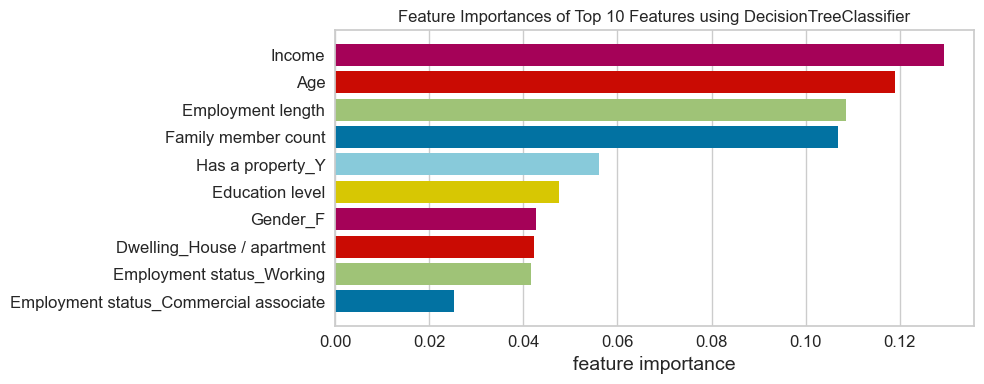







----------------------  random_forest  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



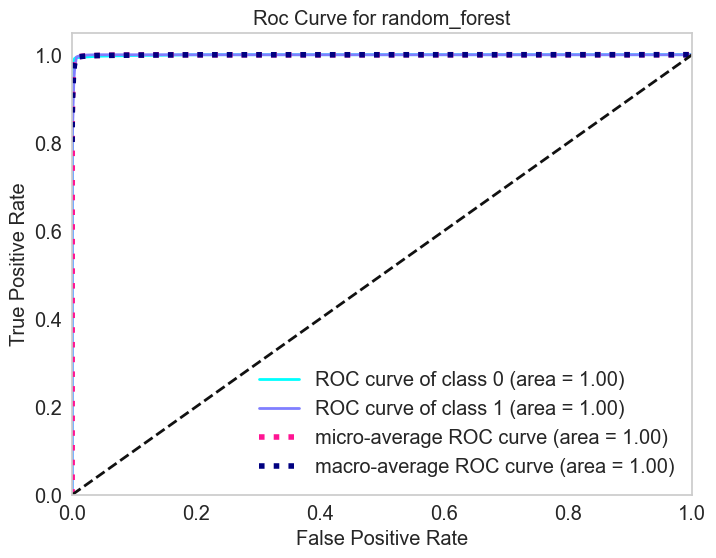

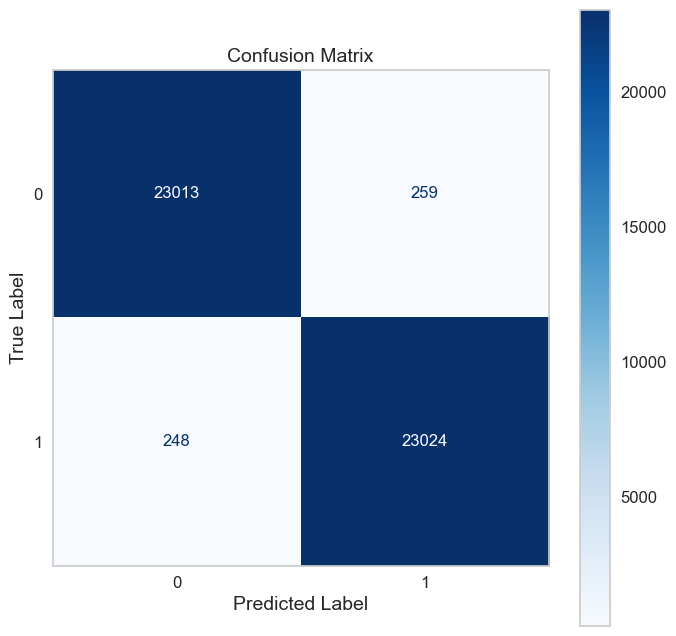

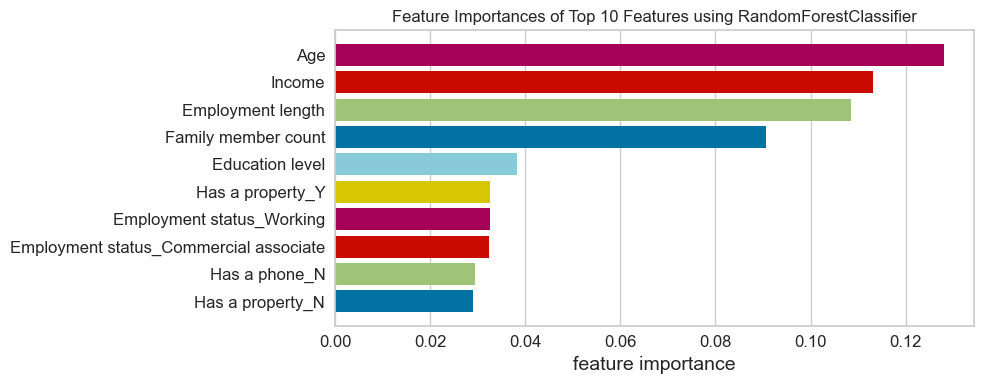

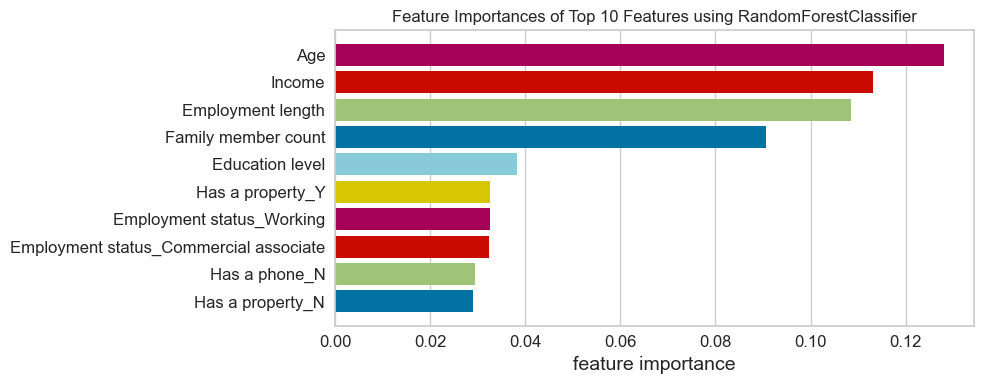







----------------------  gaussian_naive_bayes  ----------------------


              precision    recall  f1-score   support

           0       0.59      0.50      0.54     23272
           1       0.56      0.65      0.60     23272

    accuracy                           0.57     46544
   macro avg       0.58      0.57      0.57     46544
weighted avg       0.58      0.57      0.57     46544



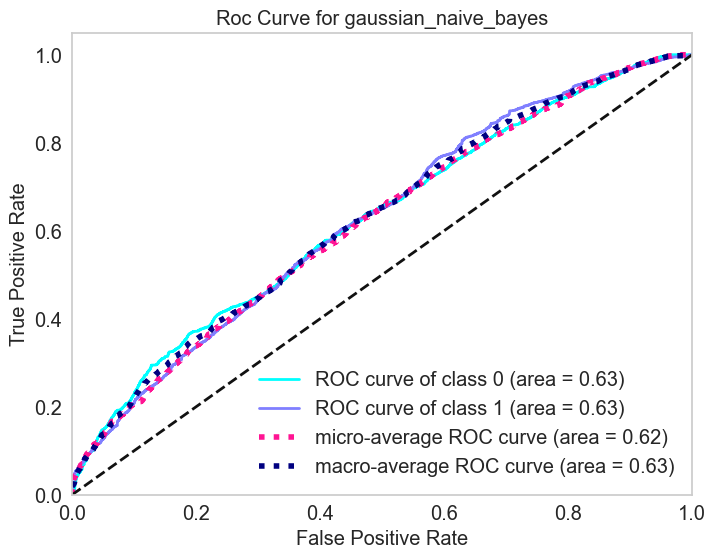

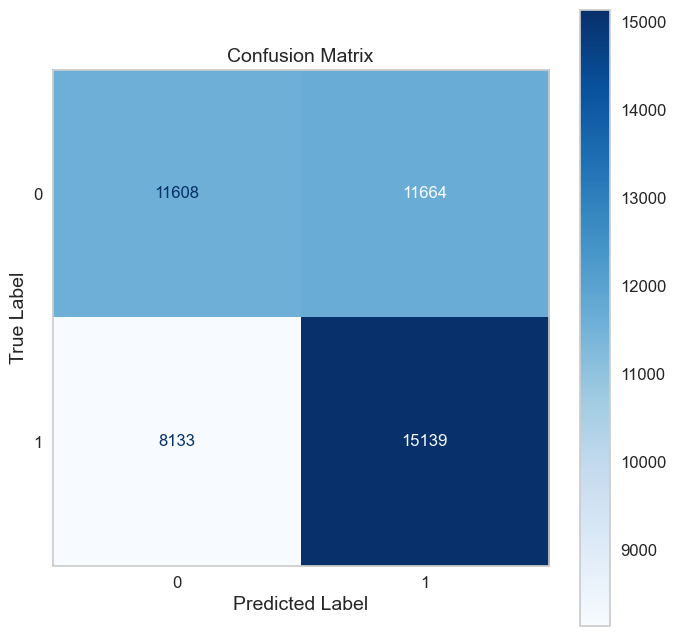



No feature importance for gaussian_naive_bayes






----------------------  k_nearest_neighbors  ----------------------


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     23272
           1       0.96      0.98      0.97     23272

    accuracy                           0.97     46544
   macro avg       0.97      0.97      0.97     46544
weighted avg       0.97      0.97      0.97     46544



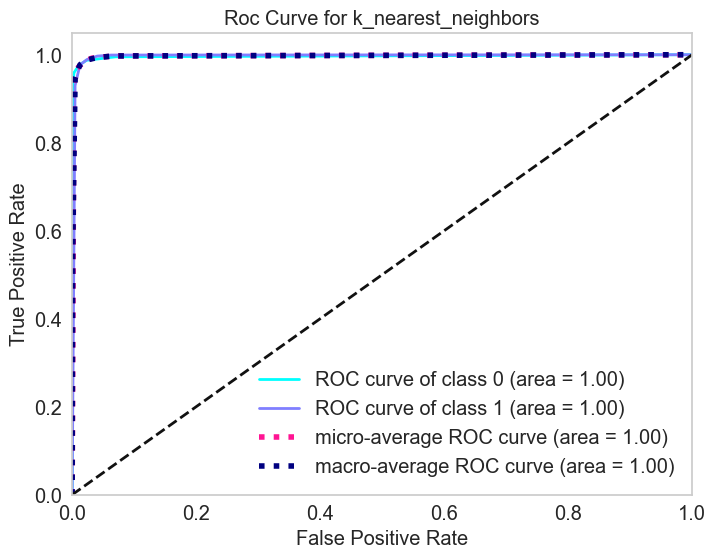

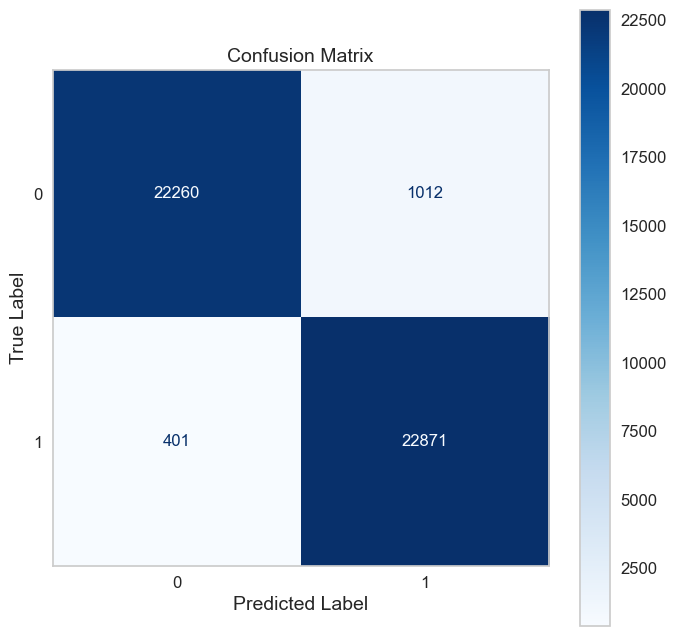



No feature importance for k_nearest_neighbors






----------------------  gradient_boosting  ----------------------


              precision    recall  f1-score   support

           0       0.90      0.90      0.90     23272
           1       0.90      0.90      0.90     23272

    accuracy                           0.90     46544
   macro avg       0.90      0.90      0.90     46544
weighted avg       0.90      0.90      0.90     46544



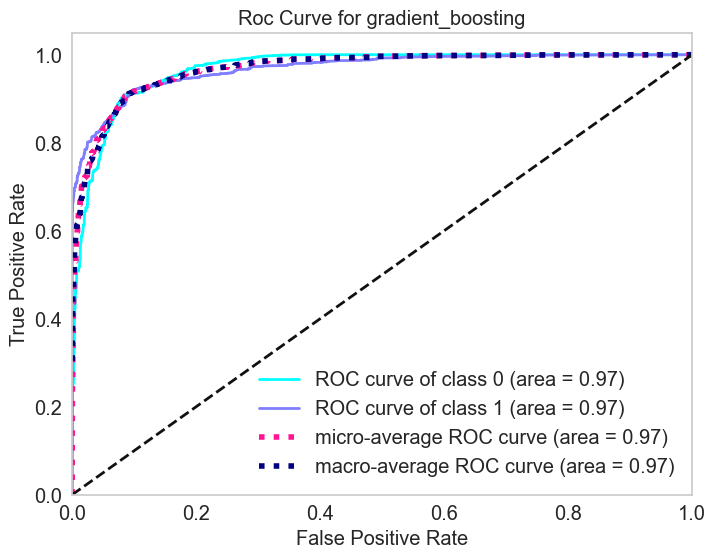

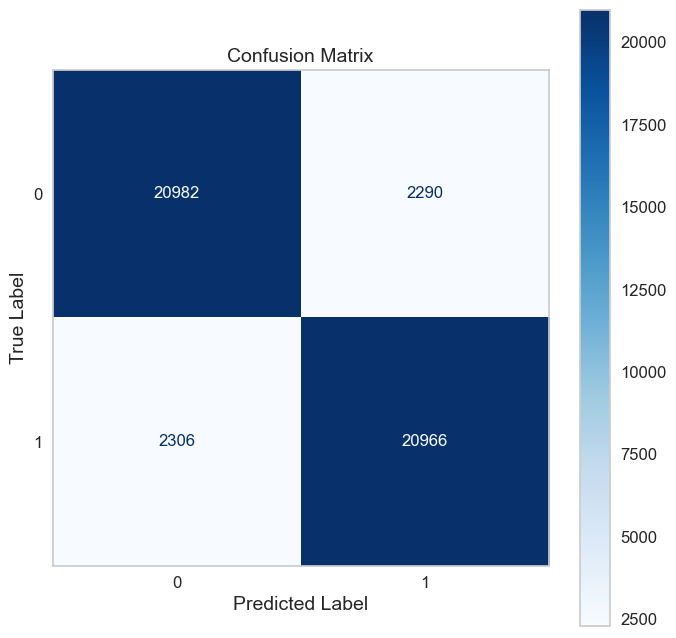

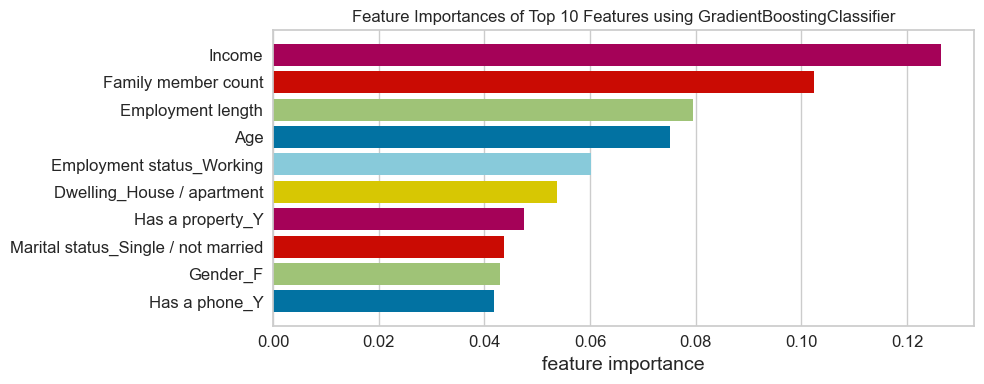

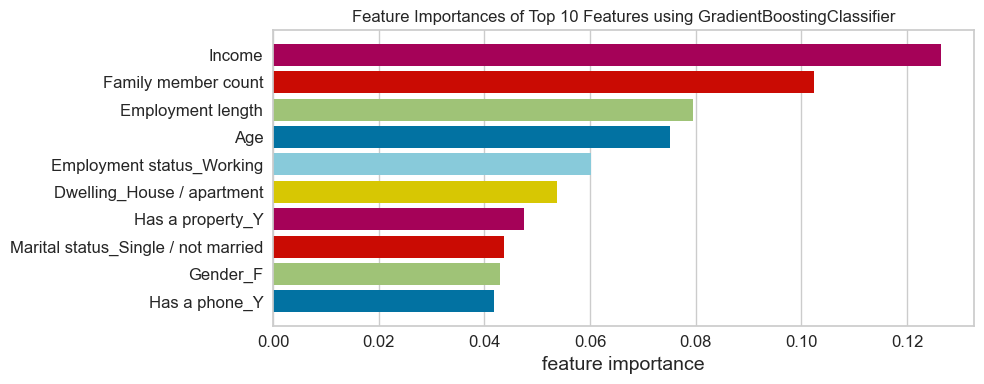







----------------------  linear_discriminaant_analysis  ----------------------


              precision    recall  f1-score   support

           0       0.59      0.56      0.57     23272
           1       0.58      0.62      0.60     23272

    accuracy                           0.59     46544
   macro avg       0.59      0.59      0.59     46544
weighted avg       0.59      0.59      0.59     46544



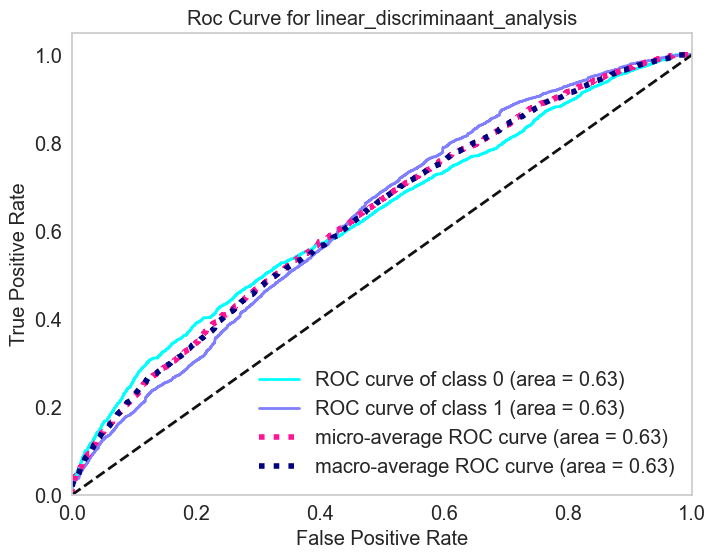

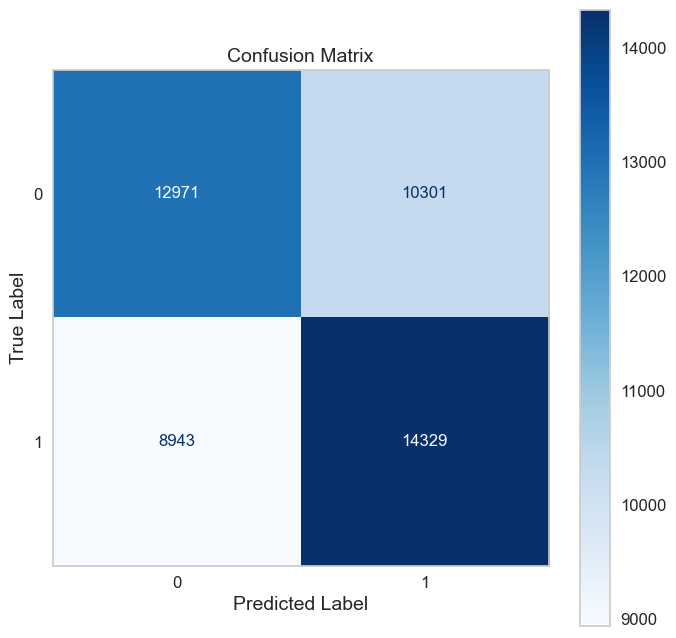

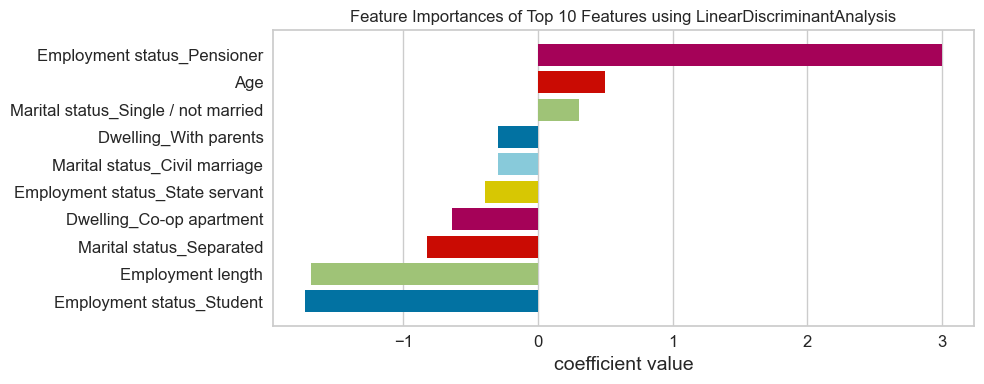

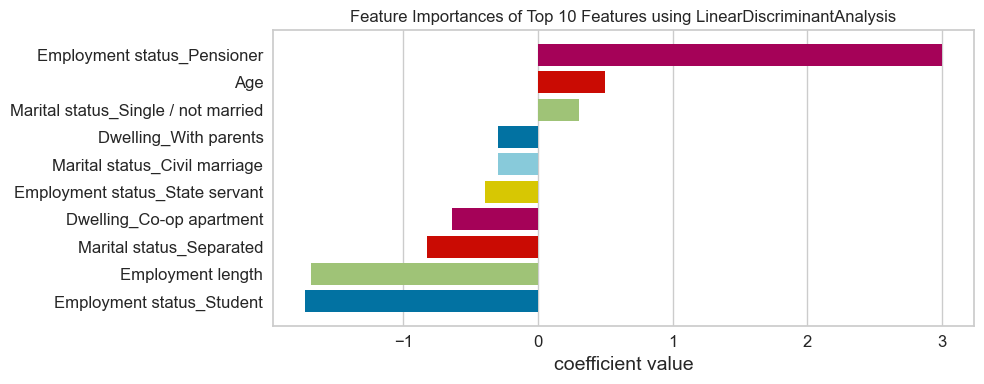







----------------------  bagging  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



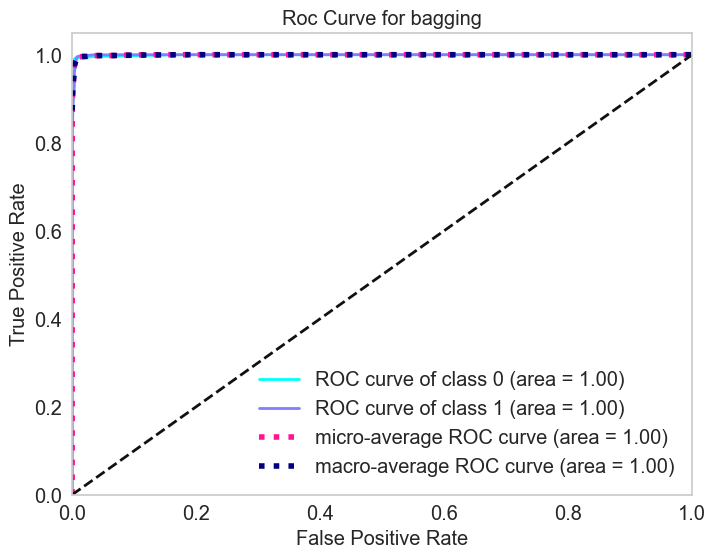

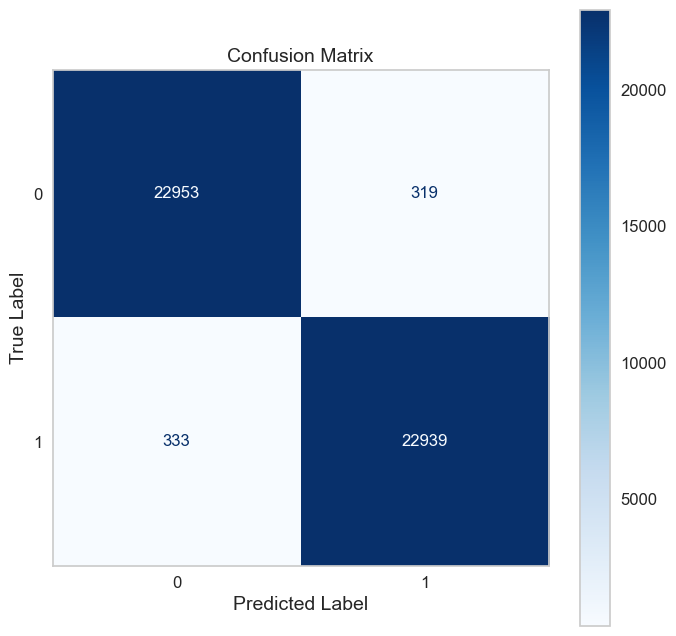



No feature importance for bagging






----------------------  neural_network  ----------------------


              precision    recall  f1-score   support

           0       0.96      0.90      0.93     23272
           1       0.91      0.96      0.94     23272

    accuracy                           0.93     46544
   macro avg       0.94      0.93      0.93     46544
weighted avg       0.94      0.93      0.93     46544



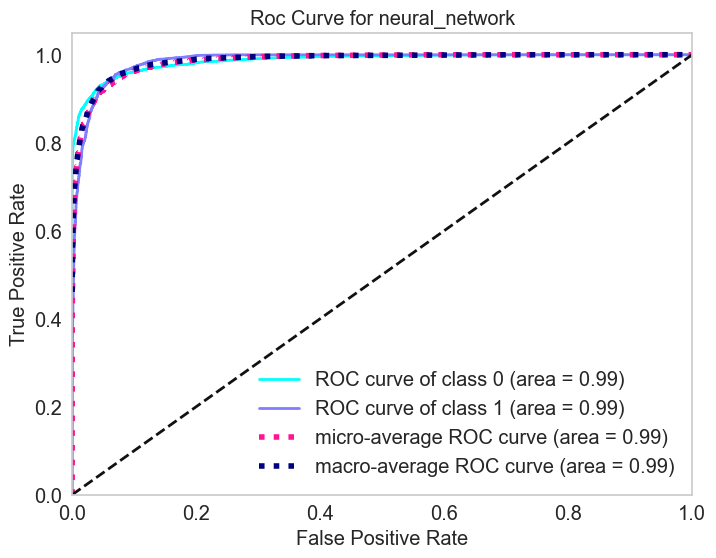

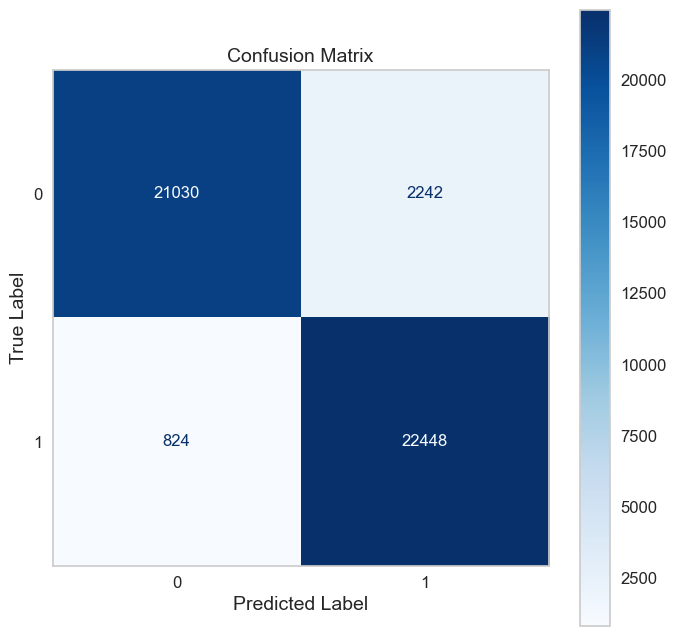



No feature importance for neural_network






----------------------  adaboost  ----------------------


              precision    recall  f1-score   support

           0       0.77      0.75      0.76     23272
           1       0.76      0.78      0.77     23272

    accuracy                           0.77     46544
   macro avg       0.77      0.77      0.77     46544
weighted avg       0.77      0.77      0.77     46544



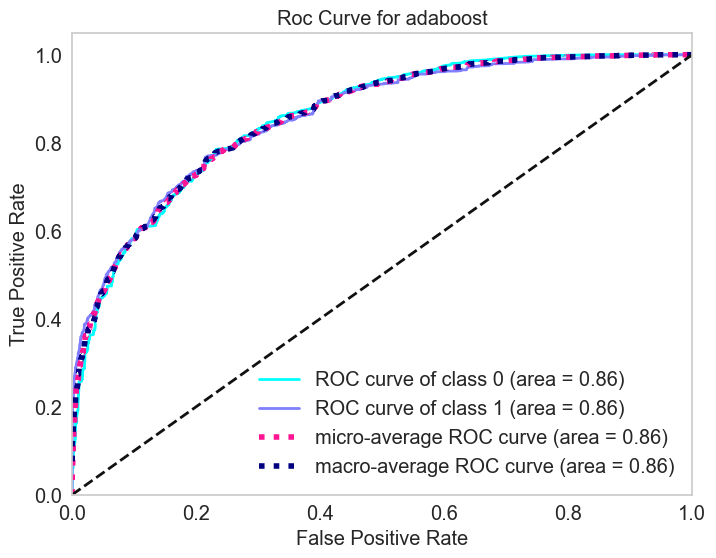

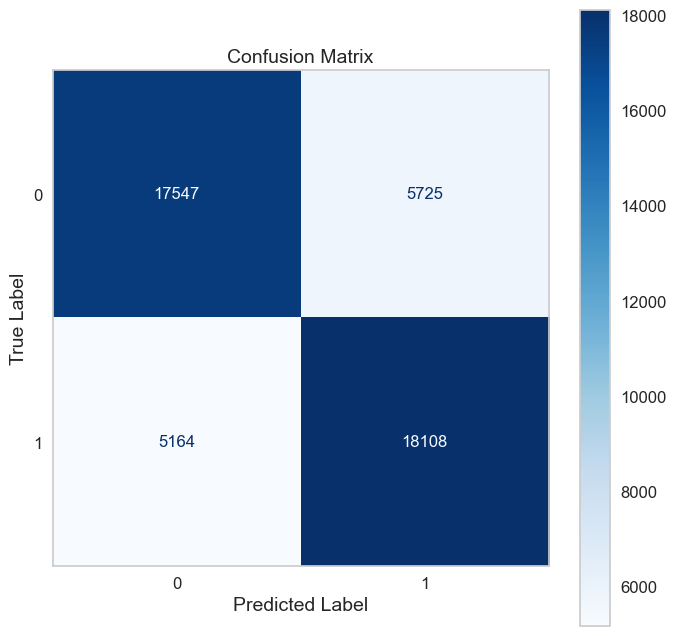

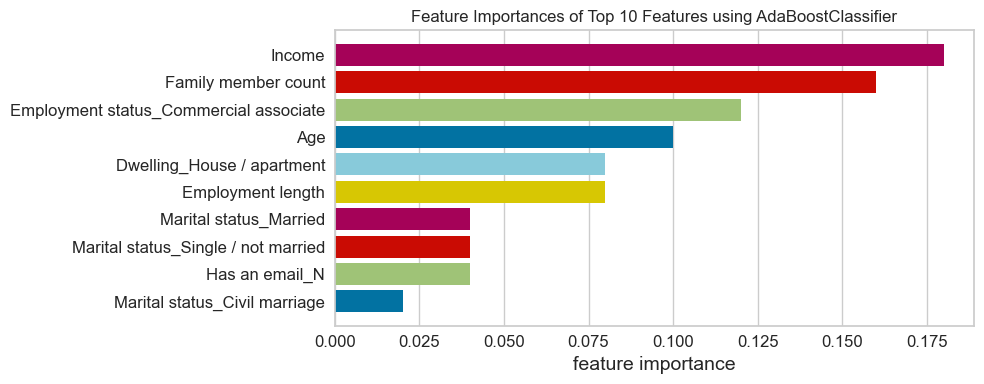

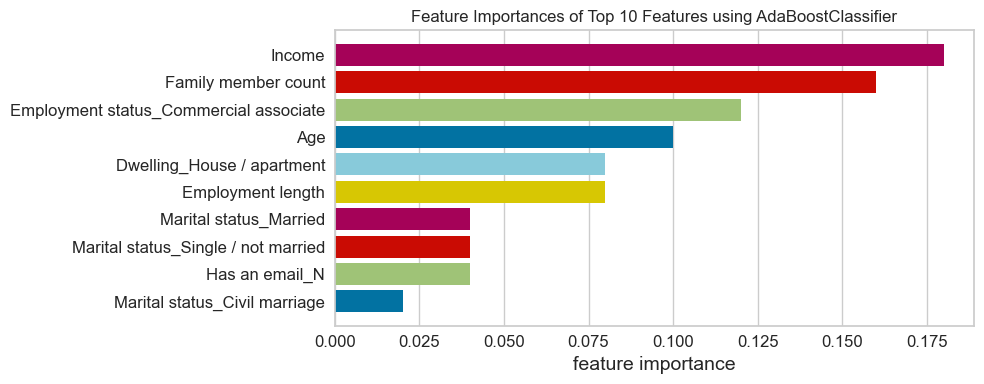







----------------------  extra_trees  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



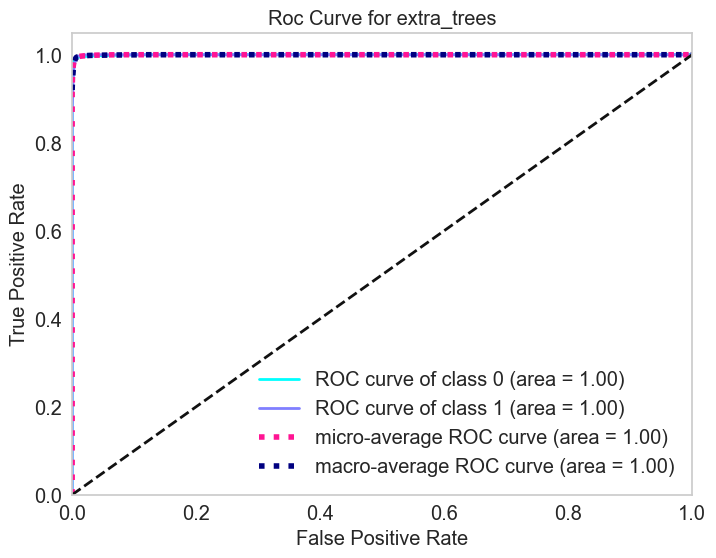

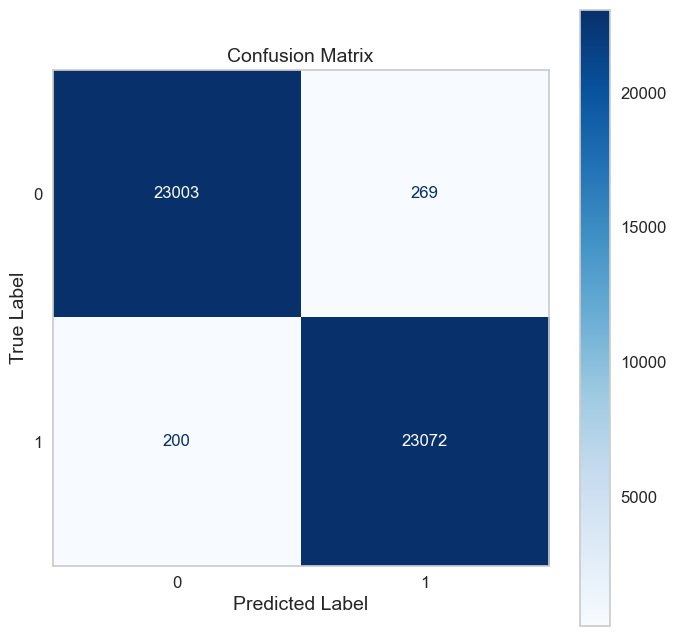

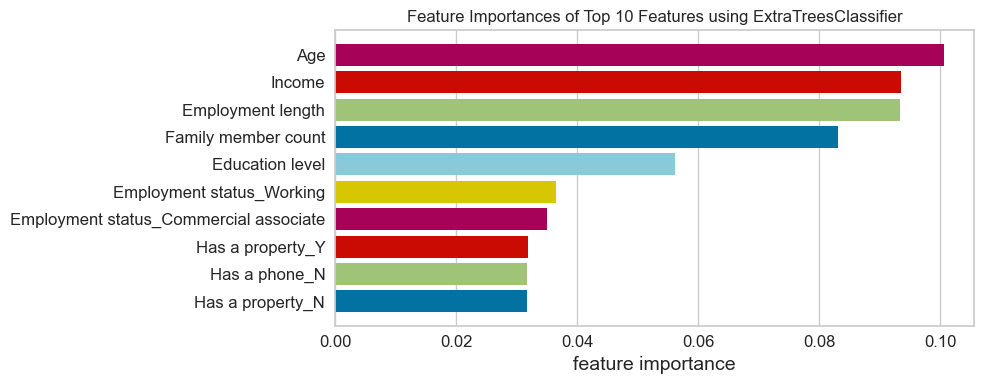

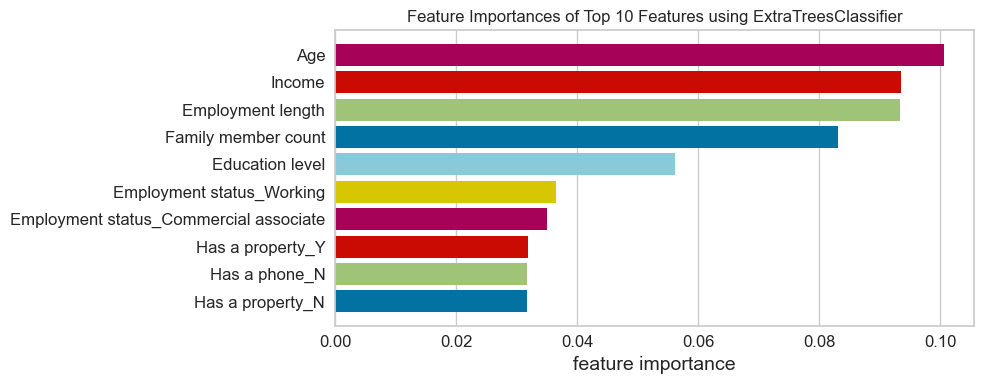

In [ ]:
# loop over all the models
for model_name,model in classifiers.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model()
    # train the model
    model_trn = train_model(model,model_name)
    # print the scores from the classification report
    score_func(model_trn, model_name)
    # plot the ROC curve
    roc_curve_func(model_trn,model_name)
    # plot the confusion matrix
    confusion_matrix_func(model_trn,model_name)
    # plot feature importance
    feat_importance_plot(model_trn, model_name)
    warnings.filterwarnings("ignore")


## Test the final model on the test set

In [ ]:
cc_test_copy.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5091261      F         N              Y               0  202500.0   
1  5096963      M         Y              N               0  675000.0   
2  5087880      F         N              N               0  234000.0   
3  5021949      F         Y              Y               0  445500.0   
4  5105705      F         Y              N               0  225000.0   

      Employment status                Education level  Marital status  \
0         State servant  Secondary / secondary special       Separated   
1  Commercial associate               Higher education         Married   
2         State servant               Higher education  Civil marriage   
3  Commercial associate               Higher education         Married   
4               Working  Secondary / secondary special         Married   

              Dwelling    Age  Employment length  Has a mobile phone  \
0    House / apartment -16834              -1692                   1   
1    House / apartment -18126               -948                   1   
2    House / apartment -21967              -5215                   1   
3    House / apartment -12477               -456                   1   
4  Municipal apartment -12155               -667                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 0            0             0  Medicine staff   
1                 0            1             0        Managers   
2                 0            0             1      Core staff   
3                 0            0             0        Managers   
4                 0            0             0        Laborers   

   Family member count  Account age Is high risk  
0                  1.0         -6.0            0  
1                  2.0        -16.0            0  
2                  2.0        -52.0            0  
3                  2.0        -54.0            0  
4                  2.0        -48.0            0

In [ ]:
cc_test_prep= full_pipeline(cc_test_copy)

In [ ]:
x_cc_test_prep, y_cc_test_prep = cc_test_prep.loc[:, cc_test_prep.columns != 'Is high risk'], cc_test_prep['Is high risk'].astype('int64')

In [ ]:
model_trn= train_model(classifiers['gradient_boosting'], 'gradient_boosting')


In [ ]:
final_prediction= model_trn.predict(x_cc_test_prep)

In [ ]:
y_cc_test_prep.shape

(11654,)

In [ ]:
print(type(final_prediction))
print(type(y_cc_test_prep))
print(final_prediction.shape)


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
(11654,)


In [ ]:
n_correct= sum(final_prediction == y_cc_test_prep)
print(n_correct)

10203


In [ ]:
print(n_correct/len(final_prediction))

0.8754933928264973
